# Importing Packages

In [29]:
# If necessary, install packages
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
!pip install gdown

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [1]:
#import packages
import numpy as np
import pandas as pd
import gdown
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
import psycopg2
import spacy
import nltk
import re
from nltk.corpus import stopwords
from tqdm import tqdm
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
import gensim
from gensim import corpora
from sklearn.metrics.pairwise import cosine_similarity
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
from scipy.stats import pearsonr
from gensim.models import CoherenceModel

/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# file IDs and table namesfor lobbying data files from Google Drive
lob_rpt = ('1CIq7XwaFTJmnUKdAvYyh53Et2XSJRX9d', 'lob_rpt')
lob_lobbyist = ('1q1ZyLvUhsxsbPLdi_CmrNH0FqLoorr6p', 'lob_lobbyist')
lob_lobbying = ('19Jef89spXbkExNpYA-s_e8GRii-0tReu', 'lob_lobbying')
lob_issue = ('18-D_vW4dAHJlvFs4ARK4lgx6KdsAXWoq', 'lob_issue')
lob_indus = ('1yldZYLcZTLIMQ5Xa-e-ecGgQGFWv5n4A', 'lob_indus')
lob_bills = ('1qqQvNXtdhyI8KYcctpVUZ3FoIwvjWaG1', 'lob_bills')
lob_agency = ('1CFi0Itpi_qg4X4wicg1FIg8S_FJfvCN0', 'lob_agency')
CatCodeReference = ('1vfVA-v-lUMuykF9efl2oDN5DJK2t1PwA', 'CatCodeReference')
CandidateIds = ('1k2lhAcuSQbn5z7NN3USPEbX_Rg5VV_Ky', 'CandidateIds')
congress_bill_data_id = ('1-MnzV0iZ2FPYiuQgOmggjmXvxGmBzYV8', 'congress_bill_data')
tweet_data = ('1Cm0hVghQf47Ep7WyP8Rx4vusSFJ9t47T','tweets_cleaned')
sponsor_tweet_match = ('1jlP28xifZx74RkWLhVPAEqooH11Ak6mA','sponsor_matches')

In [12]:
def load_csv(table, save_file=False, file_path=None, gzip=False):
    '''
    Downloads a large CSV file from Google Drive into a Pandas DataFrame.
    
    Parameters:
        file_info (tuple): A tuple containing the Google Drive file ID and the table name.
        save_file (bool): If True, the file is saved. If False, it is deleted after loading.
        file_path (str, optional): The directory path where the file should be saved. Defaults to current directory.

    Returns:
        pd.DataFrame: The loaded Pandas DataFrame.
    '''
    file_id, table_name = table
    
    # Set filename as the table name
    temp_file = f'{table_name}.csv'
   
    # If a file path is provided, join it with the filename
    if file_path:
        temp_file = os.path.join(file_path, temp_file)
   
    # Construct Google Drive download URL
    url = f'https://drive.google.com/uc?export=download&id={file_id}'
   
    # Download the file
    gdown.download(url, temp_file, quiet=False)
   
    # Load the CSV file into a Pandas DataFrame
    if gzip == False:
        df = pd.read_csv(temp_file, header=None)
    else:
        df = pd.read_csv(temp_file, header=None, compression='gzip')
  
    # Remove the file if save_file is False
    if not save_file:
        os.remove(temp_file)
    
    return df


# Data Cleaning

In [32]:
# Creating function to visualize key aspects of each dataframe. 
def glimpse(df):
    print(f'\n Shape: {df.shape}')
    print(f'\n Columns: {list(df.columns)}')
    print(f'\n Data types:\n{df.dtypes}')
    
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    
    print(f'\n Missing values:\n{missing[missing > 0]}')
    print(f'\n Missing values (%):\n{missing_percent[missing_percent > 0].round(2)}')
    
    print(f'\n First 5 rows:\n{df.head()}')
    print(f'\n Last 5 rows:\n{df.tail()}')


### Lobbying Data

In [35]:
df_lobbying = load_csv(lob_lobbying, save_file = False)
df_lobbying.columns = ['UniqID','Registrant_Raw','Registrant','IsLobbyingFirm','Client_raw','Client','UItorg','Amount','Catcode','Source','Self','IncludeNSFS','Use','Ind','Year','Type','Typelong','Affiliate']

Downloading...
From (original): https://drive.google.com/uc?export=download&id=19Jef89spXbkExNpYA-s_e8GRii-0tReu
From (redirected): https://drive.google.com/uc?export=download&id=19Jef89spXbkExNpYA-s_e8GRii-0tReu&confirm=t&uuid=4d57ba19-c29b-4499-83cf-cf769cb49156
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/lob_lobbying.csv
100%|██████████| 351M/351M [00:12<00:00, 27.1MB/s] 
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/4143072805.py:34: DtypeWarning: Columns (7,11,14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(temp_file,header=None)


In [ ]:
#Dropping unecessary columns
df_lobbying = df_lobbying.drop(
['Registrant_Raw', #Same as Registrant
 'Client_raw', # Same as Client
 'Source', # Irrelevant to analysis
 'Typelong' # Same as Type
], axis=1)

# Removing all records from lobbying dataframe without an ID
df_lobbying = df_lobbying.dropna(subset=['UniqID'])

# Capitalizing all inputs in Catcode column
df_lobbying['Catcode'] = df_lobbying['Catcode'].str.upper()

# Replacing missing values in selected boolean columns with 'n'
boolean_columns = ['IsLobbyingFirm','Affiliate','IncludeNSFS','Ind']
df_lobbying[boolean_columns] = df_lobbying[boolean_columns].fillna(value='n')

# Changing datatype of columns
df_lobbying['Amount'] = pd.to_numeric(df_lobbying['Amount'], errors='coerce')
df_lobbying = df_lobbying.dropna(subset=['Amount'])
df_lobbying['Year'] = df_lobbying['Year'].astype('int')
df_lobbying[boolean_columns] = df_lobbying[boolean_columns].apply(lambda col: col.map({'y': True, 'n': False}).astype(bool))

# Dropping all lobbying records with Use == n, as these reports have been amendent/updated and a more recent report is avaliable.  
df_lobbying = df_lobbying[df_lobbying['Use'] != 'n']
df_lobbying = df_lobbying.drop('Use',axis=1)

# Only including records after 2011.
df_lobbying = df_lobbying[df_lobbying['Year'] >= 2011]
df_lobbying = df_lobbying.drop('Affiliate',axis=1) # Dropping the Affiliate column as all records are equal to False after slicing. 

In [ ]:
# Extract quarter
df_lobbying['Quarter'] = 'Q' + df_lobbying['Type'].str.extract(r'(\d)')[0]

# Extract report type based on suffix in 'Type' column
df_lobbying['ReportType'] = df_lobbying['Type'].apply(lambda x: 
    'Standard Report' if len(x) == 2 else
    'Amendment' if x.endswith('a') else
    'Amendment (No Activity)' if x.endswith('an') else
    'No Activity' if x.endswith('n') else
    'Termination' if x.endswith('t') else
    'Termination Amendment' if x.endswith('ta') else
    'Termination (No Activity)' if x.endswith('tn') else
    'Unknown')

df_lobbying.drop('Type',axis=1) # Dropping 'Type' column as it is uneccessary now. 

,UniqID,Registrant,IsLobbyingFirm,Client,UItorg,Amount,Catcode,Self,IncludeNSFS,Ind,Year,Quarter,ReportType
0,82c5f661-a637-45ad-a3a6-b5ba18cf8962,AstraZeneca Pharmaceuticals,False,AstraZeneca Pharmaceuticals,AstraZeneca PLC,1370000.0,H4300,x,False,True,2021,Q4,Amendment
1,84ad3a9e-5864-4227-a802-e268fbf37237,David L Horne LLC,True,Multifamily Lenders Council,Multifamily Lenders Council,15000.0,F4600,n,False,True,2021,Q4,Standard Report
2,85b111b1-5d2e-4107-bc24-0921316e29a5,Echelon Government Affairs,True,Albers Group,Albers Group,10000.0,Y4000,n,False,True,2021,Q4,Standard Report
3,87822a14-12de-478c-a34d-010fa503e539,Western Telecommunications Alliance,False,Western Telecommunications Alliance,Western Telecommunications Alliance,75000.0,C4000,p,False,True,2021,Q4,Standard Report
4,87ff989d-9d12-4fef-84ef-ab69cd616894,Financial Executives International,False,Financial Executives International,Financial Executives International,21650.0,F5000,p,False,True,2021,Q4,Standard Report
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544068,0854dd96-ed91-4219-99d9-b84bf06ee2f8,American Express,False,American Express,American Express,440000.0,F1400,p,False,True,2022,Q4,Standard Report
1544069,086b65ba-0abe-4ed0-a3e9-a66c9ecc96a3,BL Partners Group,True,CTIA,CTIA,30000.0,C4300,i,False,False,2022,Q4,Standard Report
1544070,b01b51ba-d426-4750-ad00-0ea3c5aa2317,Vectis DC,True,"City of Montebello, CA","City of Montebello, CA",20000.0,X3000,n,False,True,2022,Q4,Standard Report
1544071,b0235c16-0a34-4e06-be62-f42a3bf52d6a,Nickles Group,True,Walmart Inc,Walmart Inc,80000.0,G4300,i,False,False,2022,Q4,Standard Report


### Industry

In [38]:
df_industry = load_csv(lob_indus, save_file = False)
df_industry.columns = ['Client','Sub','Total','Year','Catcode']

Downloading...
From: https://drive.google.com/uc?export=download&id=1yldZYLcZTLIMQ5Xa-e-ecGgQGFWv5n4A
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/lob_indus.csv
100%|██████████| 20.3M/20.3M [00:02<00:00, 8.96MB/s]


In [39]:
# Only including records after 2011.
df_industry = df_industry[df_industry['Year'] >= 2011]

# Capitalizing all inputs in Catcode column
df_industry['Catcode'] = df_industry['Catcode'].str.upper()

#### Catcode References

In [ ]:
df_catcode_references = load_csv(CatCodeReference, save_file = False)
df_catcode_references.columns = ['Catcode','Catname','Catorder','Industry','Sector','SectorLong']

Downloading...
From: https://drive.google.com/uc?export=download&id=1vfVA-v-lUMuykF9efl2oDN5DJK2t1PwA
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/CatCodeReference.csv
100%|██████████| 43.0k/43.0k [00:00<00:00, 1.01MB/s]


In [41]:
# merging catcode reference with industry column
df_industry = pd.merge(df_industry, df_catcode_references[['Catcode','Catname', 'Industry', 'Sector']],
                     left_on='Catcode', right_on='Catcode', how='left')

### Agency

In [42]:
df_agency = load_csv(lob_agency, save_file=False)
df_agency.columns = ['UniqID','AgencyID','Agency']

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1CFi0Itpi_qg4X4wicg1FIg8S_FJfvCN0
From (redirected): https://drive.google.com/uc?export=download&id=1CFi0Itpi_qg4X4wicg1FIg8S_FJfvCN0&confirm=t&uuid=69e951a3-e5ac-439e-9849-24fd519077bc
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/lob_agency.csv
100%|██████████| 256M/256M [00:12<00:00, 20.0MB/s] 


### Issues

In [45]:
df_issue = load_csv(lob_issue, save_file=False)
df_issue.columns = ['SI_ID','UniqID','IssueID','Issue','SpecificIssue','Year']

Downloading...
From (original): https://drive.google.com/uc?export=download&id=18-D_vW4dAHJlvFs4ARK4lgx6KdsAXWoq
From (redirected): https://drive.google.com/uc?export=download&id=18-D_vW4dAHJlvFs4ARK4lgx6KdsAXWoq&confirm=t&uuid=40ec25bc-59b6-4ca1-b1ed-4cb91579e734
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/lob_issue.csv
100%|██████████| 787M/787M [00:27<00:00, 28.4MB/s] 


In [46]:
# Only including records after 2011.
df_issue = df_issue[df_issue['Year'] >= 2011]

# Retrieving records with missing values for SpecificIssue 
specific_issue_missing = df_issue[df_issue['SpecificIssue'].isna()]

# Imputing missing values in SpecificIssue column with value from Issue column. 
df_issue['SpecificIssue'] = df_issue['SpecificIssue'].fillna(df_issue['Issue'])

# Dropping IssueID column as this has no value for our analysis. 
df_issue.drop('IssueID',axis=1)

,SI_ID,UniqID,Issue,SpecificIssue,Year
0,3001624,02e92bd6-0159-495e-9d00-8a490a0be8be,Disaster & Emergency Planning,Issues affecting manufacturer of railroad and ...,2022
1,3001625,02e92bd6-0159-495e-9d00-8a490a0be8be,Environment & Superfund,Issues affecting manufacturer of railroad and ...,2022
2,3001626,02e92bd6-0159-495e-9d00-8a490a0be8be,"Labor, Antitrust & Workplace",Issues affecting manufacturer of railroad and ...,2022
3,3001627,02e92bd6-0159-495e-9d00-8a490a0be8be,Roads & Highways,Issues affecting manufacturer of railroad and ...,2022
4,3001628,02e92bd6-0159-495e-9d00-8a490a0be8be,Railroads,Issues affecting manufacturer of railroad and ...,2022
...,...,...,...,...,...
3009859,3076640,0a62db56-bdc4-4f4c-9329-5b420066f53c,Small Business,Women's Business Center program reauthorizatio...,2022
3009860,3076641,0a6de630-f472-4dc2-a796-b58d67831573,Defense,Issues related to tungsten manufacturing,2022
3009861,3076642,0a7f2d03-7d7a-450c-b20a-a48c0fa93e92,Automotive Industry,Issues related to autonomous vehicles Cybersec...,2022
3009862,3076643,0a7f2d03-7d7a-450c-b20a-a48c0fa93e92,Banking,Financial services issues Industrial loan bank...,2022


#### Bills

In [43]:
df_bills = load_csv(lob_bills, save_file=False)
df_bills.columns = ['B_ID', 'SI_ID', 'CongNo', 'Bill_Name']

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1qqQvNXtdhyI8KYcctpVUZ3FoIwvjWaG1
From (redirected): https://drive.google.com/uc?export=download&id=1qqQvNXtdhyI8KYcctpVUZ3FoIwvjWaG1&confirm=t&uuid=914e77a4-d45a-42cb-920f-939dcd64ffc9
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/lob_bills.csv
100%|██████████| 219M/219M [00:07<00:00, 29.1MB/s] 


In [47]:
# Importing Year column from the issues dataframe 
# this is to impute missing values for congress number by cross-referencing Year with a dictionary containing Year and Congress No. at the time. 
df_bills = df_bills.merge(df_issue[['SI_ID', 'Year']], on='SI_ID', how='left')

# Dictionary mapping Congress by year. Retrieved from: https://www.congress.gov/help/field-values/congresses
congress_number_by_year = {
2025: 119.0, 2026: 119.0,2023: 118.0,2024: 118.0,2021: 117.0,2022: 117.0,2019: 116.0,2020: 116.0,
2017: 115.0,2018: 115.0,2015: 114.0,2016: 114.0,2013: 113.0,2014: 113.0,2011: 112.0,
2012: 112.0,2009: 111.0,2010: 111.0,2007: 110.0,2008: 110.0,2005: 109.0,2006: 109.0,
2003: 108.0,2004: 108.0,2001: 107.0,2002: 107.0,1999: 106.0,2000: 106.0,1998: 105.0
}

# Impute missing values
df_bills['CongNo'] = df_bills['CongNo'].fillna(df_bills['Year'].map(congress_number_by_year))

# Dropping 'Year' column again
df_bills = df_bills.drop('Year',axis=1)

# Converting datatype of CongNo column
df_bills['CongNo'] = df_bills['CongNo'].astype('Int64')

In [49]:
# Dropping records with missing value in CongNo, as these records are not connected to Lobby Issues dataframe through Foreign Key - and are hence excessive
df_bills = df_bills.dropna(subset=['CongNo'])

In [ ]:
df_bills['Bill_Name'] = df_bills['Bill_Name'].str.replace(r'^H\.?(\d+)$', r'H.R.\1', regex=True)

### Lobbyist

In [51]:
df_lobbyist = load_csv(lob_lobbyist,save_file=False)
df_lobbyist.columns = ['UniqID','Lobbyist_raw','Lobbyist','LobbyistID','Year','OfficialPosition','CID','Formercongmem']

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1q1ZyLvUhsxsbPLdi_CmrNH0FqLoorr6p
From (redirected): https://drive.google.com/uc?export=download&id=1q1ZyLvUhsxsbPLdi_CmrNH0FqLoorr6p&confirm=t&uuid=00026638-66f3-4c2a-a2eb-86c450744cb5
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/lob_lobbyist.csv
100%|██████████| 410M/410M [00:12<00:00, 34.0MB/s] 


In [52]:
# Only including records after 2011.
df_lobbyist = df_lobbyist[df_lobbyist['Year'] >= 2011]

# Dropping missing values
df_lobbyist = df_lobbyist.dropna(subset=['LobbyistID'])
df_lobbyist = df_lobbyist.dropna(subset=['Year']) # Dropping this record as well as it does not have any UniqId

# Dropping uneccessary column
df_lobbyist = df_lobbyist.drop('Lobbyist_raw',axis=1)

# Chaging data type of Year column
df_lobbyist['Year'] = df_lobbyist['Year'].astype('Int64')

# Imputing missing values in 'Formercongmem' column -- if CID = Blank --> 'n', if CID != Blank --> 'y'
df_lobbyist.loc[df_lobbyist['Formercongmem'].isna(), 'Formercongmem'] = df_lobbyist['CID'].apply(
    lambda x: 'n' if pd.isna(x) else 'y')

# Changing data type of Formercongmem column to Boolean
df_lobbyist['Formercongmem'] = df_lobbyist['Formercongmem'].map({'y': True, 'n': False}).astype(bool)

# Imputing missing values for CID column
df_lobbyist['CID'] = df_lobbyist['CID'].fillna(value='Not Congress Member')

In [53]:
# Pringint unique values in official position column
print(len(df_lobbyist['OfficialPosition'].unique()))

# Considering the amount of missing values and unique values - OfficialPosition column is dropped due to providing small value to further analysis
df_lobbyist = df_lobbyist.drop('OfficialPosition',axis=1)

41623


#### Candidate IDs

In [54]:
df_candidate = load_csv(CandidateIds,save_file=False)
df_candidate.columns = ['CID', 'CRPName', 'Party', 'DistIDRunFor', 'FECCandID']

Downloading...
From: https://drive.google.com/uc?export=download&id=1k2lhAcuSQbn5z7NN3USPEbX_Rg5VV_Ky
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/CandidateIds.csv
100%|██████████| 970k/970k [00:00<00:00, 4.51MB/s]


In [55]:
# Merge on the common 'CID' column to include the columns from df_candidate
df_lobbyist = pd.merge(
    df_lobbyist,
    df_candidate[['CID', 'CRPName', 'Party', 'DistIDRunFor', 'FECCandID']],
    on='CID',
    how='left'
)

## Narrowing Scope

In [56]:
# Only including lobbying reports related to specific issues
chosen_issues = ['Health Issues', 'Medical Research & Clin Labs', 'Pharmacy', 'Medicare & Medicaid', 'Science & Technology', 'Taxes']
df_issue = df_issue[df_issue['Issue'].isin(chosen_issues)]

In [57]:
# Dropping lobbying reports that are no longer referenced in df_issue table
df_lobbying = df_lobbying[df_lobbying['UniqID'].isin(df_issue['UniqID'])]

# dropping lobbyist records for lobbyists that are no longer involved in the lobbying reports from cleaned df_lobbying df.
df_lobbyist = df_lobbyist[df_lobbyist['UniqID'].isin(df_lobbying['UniqID'])]

# droppping bills records that are not related to any of the chosen issues. 
df_bills = df_bills[df_bills['SI_ID'].isin(df_issue['SI_ID'])]

# droppping agency records that are not related to any of the current reports. 
df_agency = df_agency[df_agency['UniqID'].isin(df_lobbying['UniqID'])]

# droppping industry records that are not related to any of the current reports.
df_industry = df_industry[df_industry['Catcode'].isin(df_lobbying['Catcode'])]

#### Importing additional information about bills

In [58]:
df_congress_bill_data = load_csv(congress_bill_data_id, save_file=False)
df_congress_bill_data.columns = ['bill_number','congress_number','bill_title','policy_area','introduced_date',
                                 'bill_type','full_bill_code','sponsor_name','sponsor_party','sponsor_bioguide_id']
df_congress_bill_data = df_congress_bill_data.iloc[1:] # dropping first row of dataframe

Downloading...
From: https://drive.google.com/uc?export=download&id=1-MnzV0iZ2FPYiuQgOmggjmXvxGmBzYV8
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/congress_bill_data.csv
100%|██████████| 4.26M/4.26M [00:00<00:00, 9.16MB/s]


In [ ]:
df_congress_bill_data['congress_number'] = df_congress_bill_data['congress_number'].astype('Int64')

df_congress_bill_data = df_congress_bill_data.merge(
    df_bills[['B_ID', 'CongNo', 'Bill_Name']],
    left_on=['full_bill_code', 'congress_number'],
    right_on=['Bill_Name', 'CongNo'],
    how='left'
).drop(columns=['Bill_Name', 'CongNo'],axis = 1)  # Drop duplicate columns

In [60]:
# Dropping bill records we don't have any data sponsor data on. 
df_bills = df_bills[df_bills['B_ID'].isin(df_congress_bill_data['B_ID'])]

## Restructuring Data for Efficiency

#### Main Table

In [ ]:
# Merge all tables on 'UniqID' to capture all required fields
df_master_table = (
    df_lobbying
    .merge(df_agency, on='UniqID', how='left')
    .merge(df_lobbyist, on='UniqID', how='left')
    .merge(df_issue, on='UniqID', how='left')
)

# Select columns with unique identifer frome each relevant table
df_master_table = df_master_table[['UniqID', 'AgencyID', 'LobbyistID', 'SI_ID']].drop_duplicates()

# Add a unique MasterID
df_master_table.insert(0, 'MasterID', range(1001, 1001 + len(df_master_table)))

df_master_table['AgencyID'] = df_master_table['AgencyID'].astype('Int64') # changing data type of AgencyID column

In [ ]:
# we observe that some lobbying instances are not related to a Lobbyist or Agency. 
df_master_table.isnull().sum()
df_master_table[['AgencyID','LobbyistID']] = df_master_table[['AgencyID','LobbyistID']].replace({np.nan: None}) # Replace NaN with None for SQL compatibility

In [63]:
# Include year column in master table
df_master_table = pd.merge(
    df_master_table,
    df_lobbying[['UniqID','Year']],
    on='UniqID',
    how='left'
)

#### Industry Table

In [ ]:
# Ensure all unique combinations of Catcode-Year from the Lobbying dataframe are captured
unique_catcode_years = df_lobbying[['Catcode', 'Year']].drop_duplicates()

# Summarize lobbying data (only including Ind=True records)
lobbying_filtered_summary = (
    df_lobbying[df_lobbying['Ind'] == True]  # Only include records where Ind=True
    .groupby(['Catcode', 'Year'])
    .agg(
        Total_Lobbying_Reported=('Amount', 'sum'),  # Sum lobbying spending that counts towards industry totals
    )
    .reset_index())

# Summarize industry data by Catcode + Year
industry_summary = (
    df_industry.groupby(['Catcode', 'Year'])
    .agg(
        Total_Lobbying_Spending=('Total', 'sum'),  # Sum total spending per industry per year
        Unique_Clients=('Client', 'nunique')  # Count unique clients per industry per year
    )
    .reset_index())

# Ensure all unique Catcode-Year combinations from Lobbying Data exist in the final dataset
df_industry_summary = unique_catcode_years.merge(
    lobbying_filtered_summary, on=['Catcode', 'Year'], how='left').merge(
    industry_summary, on=['Catcode', 'Year'], how='left'
    )

# Fill NaN values with 0 for numerical columns (in case no data exists for that Catcode-Year in a dataset)
df_industry_summary.fillna({'Total_Lobbying_Reported': 0, 'Total_Lobbying_Spending': 0, 'Unique_Clients': 0}, inplace=True)

# Extract unique Catname, Industry, and Sector information per Catcode
df_industry_unique = df_industry[['Catcode', 'Catname', 'Industry', 'Sector']].drop_duplicates()

# Merge additional industry metadata
df_industry_summary = df_industry_summary.merge(
    df_industry_unique,
    on='Catcode',
    how='left'
)


#### Agency Table

In [65]:
# Dropping duplicate entries of AgencyID and Agency combination
df_agency_final = df_agency[['AgencyID', 'Agency']].drop_duplicates()

# Displaying potential duplicates in AgencyID column
df_agency_final[df_agency_final.duplicated(subset=['AgencyID'], keep=False)].sort_values('AgencyID')

# Define the list of (Agency, AgencyID) tuples to drop
to_drop = [
    (54,'Federal Deposit Insurance Commission'),
    (86, 'Postal Rate Commission'),
    (124, 'Defense Security Assistance Agency'),
    (199,'ACCESS Board'),
    (238, 'Office of National Aids Policy')
]

# Drop rows that match both Agency and AgencyID
df_agency_final = df_agency_final[~df_agency_final.apply(tuple, axis=1).isin(to_drop)]


#### Lobbyist Table

In [66]:
df_lobbyist_final = df_lobbyist[['LobbyistID', 'Lobbyist', 'Formercongmem', 'Party']].drop_duplicates()

In [67]:
# Imputing missing values for political party for former congress-men
missing_political_party = {
    'Y0000022381L' : 'R','Y0000014172L' : 'R','Y0000041393L' : 'R','Y0000041198L' : 'D','Y0000031994L' : 'R','Y0000040464L' : 'R',
    'Y0000041214L' : 'D','Y0000040343L' : 'R','Y0000026610L' : 'R','Y0000042045L' : 'R','Y0000041638L' : 'R','Y0000027785L' : 'R',
    'Y0000041137L' : 'D','Y0000009728L' : 'R','Y0000041060L' : 'R','Y0000027979L' : 'R','Y0000040107L' : 'D','Y0000030165L' : 'D',
    'Y0000008316L' : 'R','Y0000041693L' : 'D','Y0000041437L' : 'D','Y0000000158L' : 'R','Y0000040464M' : 'R','Y0000040575L' : 'R',
    'Y0000042027L' : 'D','Y0000009666L' : 'D','Y0000038683L' : 'R','Y0000046534L' : 'R','Y0000041860L' : 'D','Y0000028461L' : 'R',
    'Y0000014475L' : 'D','Y0000017606L' : 'D','Y0000011321L' : 'R','Y0000042041L' : 'R','Y0000041375L' : 'D','Y0000041586L' : 'D',
    'Y0000041364L' : 'D','Y0000017415L' : 'R','Y0000008436L' : 'R','Y0000045198L' : 'R','Y0000006265L' : 'R','Y0000035408L' : 'R',
    'Y0000040391L' : 'R','Y0000041827L' : 'R','Y0000041317L' : 'R','Y0000042035L' : 'D','Y0000040953L' : 'D','Y0000012587L' : 'D',
    'Y0000000545L' : 'D','Y0000005168L' : 'D','Y0000005429L' : 'R','Y0000028048L' : 'R','Y0000039653L' : 'D','Y0000015675L' : 'D',
    'Y0000014080L' : 'D','Y0000041094L' : 'D','Y0000025402L' : 'D','Y0000033912L' : 'R','Y0000027950L' : 'R','Y0000003201L' : 'D',
    'Y0000046532L' : 'D','Y0000027397L' : 'D','Y0000040428L' : 'R','Y0000017752L' : 'D','Y0000000969L' : 'D','Y0000016284L' : 'R',
    'Y0000001540L' : 'D','Y0000008788L' : 'D','Y0000055101L' : 'D','Y0000019350L' : 'R','Y0000028862L' : 'D','Y0000047746L' : 'D',
    'Y0000020586L' : 'D','Y0000007555L' : 'R'
    }

df_lobbyist_final['Party'] = df_lobbyist_final['Party'].fillna(df_lobbyist_final['LobbyistID'].map(missing_political_party))

In [ ]:
# Define a function to handle duplicates based on 'Party' column
def resolve_duplicates(group):
    # If there's only one entry, return it
    if len(group) == 1:
        return group

    # Check if the first occurrence has a missing value in 'Party'
    if pd.isna(group.iloc[0]['Party']):
        return group.iloc[1:]  # Keep the second entry
    else:
        return group.iloc[:1]  # Keep the first entry

df_lobbyist_final = df_lobbyist_final.groupby('LobbyistID', group_keys=False).apply(resolve_duplicates).reset_index(drop=True)

/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/3952088457.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_lobbyist_final = df_lobbyist_final.groupby('LobbyistID', group_keys=False).apply(resolve_duplicates).reset_index(drop=True)


#### Issue Table

In [ ]:
# Only keeping necessary columns for new table
df_issue_final = df_issue[['SI_ID','Issue','SpecificIssue']]

df_issue_final = df_issue_final.merge(
    df_bills[['SI_ID','B_ID']],
    on = 'SI_ID',
    how = 'left'
)

#### Bills Table

In [70]:
df_bills_final = df_bills[['B_ID','CongNo','Bill_Name']] # only keeping necessary columns
df_bills_final = df_bills_final[['B_ID', 'CongNo', 'Bill_Name']].drop_duplicates() # Dropping duplicates from dataframe. 

In [ ]:
# checking if all B_ID's from parent table exists in child table. 
missing_b_ids_in_bills = df_issue_final[~df_issue_final['B_ID'].isin(df_bills_final['B_ID'])]
print(missing_b_ids_in_bills['B_ID'].unique()) # all missing ID's from parent table are missing values. 

# checking if all B_ID's in child table table exists in parent table. 
all_b_ids_exist_in_issue = df_bills_final['B_ID'].isin(df_issue_final['B_ID']).all()
print(all_b_ids_exist_in_issue)


[nan]
True


#### Sponsor Table

In [ ]:
df_sponsor = df_congress_bill_data[['sponsor_bioguide_id','B_ID','sponsor_name','sponsor_party']]
df_sponsor.rename(columns={'sponsor_bioguide_id':'SponsorID','sponsor_name':'SponsorName','sponsor_party':'SponsorParty'},inplace=True)

/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/658583622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sponsor.rename(columns={'sponsor_bioguide_id':'SponsorID','sponsor_name':'SponsorName','sponsor_party':'SponsorParty'},inplace=True)


In [ ]:
# checking if all B_ID's from parent table exists in child table. 
missing_b_ids_in_sponsor = df_bills_final[~df_bills_final['B_ID'].isin(df_sponsor['B_ID'])]
print(missing_b_ids_in_sponsor['B_ID'].unique()) # all missing ID's from parent table are missing values. 

# checking if all B_ID's in child table table exists in parent table. 
all_b_ids_exist_in_bills = df_sponsor['B_ID'].isin(df_bills_final['B_ID']).all()
print(all_b_ids_exist_in_bills)

[]
True


In [ ]:
df_sponsor.isnull().sum() # we observe that 95 bills are missing. these are either Reserved for Speaker, or dosen't actually have a Sponsor.

SponsorID       95
B_ID             0
SponsorName     95
SponsorParty    95
dtype: int64

In [76]:
df_sponsor = df_sponsor[['SponsorID','B_ID','SponsorName','SponsorParty']].drop_duplicates() # dropping duplicate records

In [72]:
# check if one bill can be related to multiple sponsors
duplicated_bills = df_sponsor[df_sponsor.duplicated(subset=['B_ID'], keep=False)]
duplicated_bills

,SponsorID,B_ID,SponsorName,SponsorParty


In [77]:
# considering we have a one-to-many relationship between sponsor and bills, we can simply merge the two tables by including sponsor information in the Bills Table. 
df_bills_final = df_bills_final.merge(df_sponsor[['B_ID','SponsorName','SponsorParty']], on = 'B_ID', how = 'left')

### Industry and Lobbying Table

In [ ]:
# Create foreign key for df_industry_summary table my concatenating catcode and year in df_lobbying
df_lobbying['industry_id'] = df_lobbying['Catcode'].astype(str) + '_' + df_lobbying['Year'].astype(str)

# dropping year and catcode column from df_lobbying
df_lobbying = df_lobbying.drop(columns=['Catcode','Year'],axis = 1)

# creating industry_id and dropping year column for df_industry_summary
df_industry_summary['industry_id'] = df_industry_summary['Catcode'].astype(str) + '_' + df_industry_summary['Year'].astype(str)
df_industry_summary = df_industry_summary.drop(columns=['Year'],axis = 1)

## Create Junction Table between Issue and Bills: Issue_Bills

In [ ]:
#create junction dataframe
df_bills_issues = df_issue_final[['SI_ID', 'B_ID']].drop_duplicates()

# cleaning issue table to not reference bills
df_issue_final = df_issue_final.drop(columns=['B_ID'])

In [80]:
df_bills_issues.isnull().sum() # about 15% of issue records are not related to a bill.  
df_bills_issues['B_ID'] = df_bills_issues['B_ID'].replace({np.nan: None}) # Replace NaN with None for SQL compatibility

In [ ]:
#ensure we don't have duplicated entries for PKs in df_bills_final and df_issues_final
df_bills_final[df_bills_final.duplicated(subset='B_ID', keep=False)] # no duplciates
df_issue_final[df_issue_final.duplicated(subset='SI_ID', keep=False)] # duplicats, only keep first occurence of 'SI_ID'
df_issue_final = df_issue_final.drop_duplicates(subset='SI_ID', keep='first')

## Preparing Data for Relational Database Management System (RDBMS)

In [ ]:
# Database connection parameters
host = 'localhost'
database = 'USLobbyism2'
user = 'postgres'
password = 'MasterThesis'
port = 5433


connection = psycopg2.connect(
    host=host,
    database=database,
    user=user,
    password=password,
    port=port 
)

cur = connection.cursor()

# Create the dimension tables
cur.execute('''
    CREATE TABLE IF NOT EXISTS industry_dim (
        industry_id VARCHAR(36) PRIMARY KEY,
        Catcode CHAR(5),
        Catname VARCHAR(50),
        Industry VARCHAR(36),
        Sector VARCHAR(50),
        UniqueClients INT,
        Total_Lobbying_Reported FLOAT,
        Total_Lobbying_Spending FLOAT
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS lobbying_report_dim (
        UniqID VARCHAR(36) PRIMARY KEY,
        Registrant VARCHAR(50),
        IsLobbyingFirm BOOLEAN,
        Client VARCHAR(50),
        UItorg VARCHAR(50),
        Amount FLOAT,
        Self CHAR(1),
        IncludeNSFS BOOLEAN,
        Ind BOOLEAN,
        Quarter CHAR(2),
        ReportType VARCHAR(36),
        industry_id VARCHAR(36),
        FOREIGN KEY (industry_id) REFERENCES industry_dim(industry_id) ON DELETE CASCADE
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS agency_dim (
        AgencyID CHAR(4) PRIMARY KEY,
        Agency VARCHAR(80)
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS lobbyist_dim (
        LobbyistID VARCHAR(12) PRIMARY KEY,
        LobbyistName VARCHAR(50),
        Formercongmem BOOLEAN,
        Party CHAR(4)
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS bills_dim (
        B_ID VARCHAR(18) PRIMARY KEY,
        BillName CHAR(15),
        CongNo CHAR(3),
        SponsorName VARCHAR(255),
        SponsorParty CHAR(4)
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS issue_dim (
        SI_ID BIGINT PRIMARY KEY,
        Issue VARCHAR(50),
        SpecificIssue TEXT
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS bills_issues_junction (
        JunctionID SERIAL PRIMARY KEY,
        B_ID VARCHAR(18),
        SI_ID BIGINT NOT NULL,
        FOREIGN KEY (B_ID) REFERENCES bills_dim(B_ID) ON DELETE SET NULL,
        FOREIGN KEY (SI_ID) REFERENCES issue_dim(SI_ID) ON DELETE CASCADE
    )
''')

cur.execute('''
    CREATE TABLE IF NOT EXISTS main_fact (
        MasterID SERIAL PRIMARY KEY,
        UniqID VARCHAR(36) NOT NULL,
        LobbyistID VARCHAR(12),
        SI_ID BIGINT NOT NULL,
        AgencyID CHAR(4),
        Year INT,
        FOREIGN KEY (UniqID) REFERENCES lobbying_report_dim(UniqID) ON DELETE CASCADE,
        FOREIGN KEY (LobbyistID) REFERENCES lobbyist_dim(LobbyistID) ON DELETE SET NULL,
        FOREIGN KEY (SI_ID) REFERENCES issue_dim(SI_ID) ON DELETE CASCADE,
        FOREIGN KEY (AgencyID) REFERENCES agency_dim(AgencyID) ON DELETE SET NULL
    )
''')

# Insert data into tables

cur.executemany('''
    INSERT INTO industry_dim (industry_id, Catcode, Catname, Industry, Sector, UniqueClients, Total_Lobbying_Reported, Total_Lobbying_Spending)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
''', df_industry_summary[['industry_id','Catcode', 'Catname', 'Industry', 'Sector', 'Unique_Clients', 'Total_Lobbying_Reported', 'Total_Lobbying_Spending']].values.tolist())

cur.executemany('''
    INSERT INTO lobbying_report_dim (UniqID, Registrant, IsLobbyingFirm, Client, UItorg, Amount, Self, IncludeNSFS, Ind, Quarter, ReportType, industry_id)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
''', df_lobbying[['UniqID','Registrant','IsLobbyingFirm','Client','UItorg','Amount','Self','IncludeNSFS','Ind','Quarter','ReportType','industry_id']].values.tolist())

cur.executemany('INSERT INTO agency_dim (AgencyID, Agency) VALUES (%s, %s)', df_agency_final[['AgencyID', 'Agency']].values.tolist())
cur.executemany('INSERT INTO lobbyist_dim (LobbyistID, LobbyistName, Formercongmem, Party) VALUES (%s, %s, %s, %s)', df_lobbyist_final[['LobbyistID','Lobbyist', 'Formercongmem', 'Party']].values.tolist())
cur.executemany('INSERT INTO bills_dim (B_ID, BillName, CongNo, SponsorName, SponsorParty) VALUES (%s, %s, %s, %s, %s)', df_bills_final[['B_ID','Bill_Name', 'CongNo','SponsorName','SponsorParty']].values.tolist())
cur.executemany('INSERT INTO issue_dim (SI_ID, Issue, SpecificIssue) VALUES (%s, %s, %s)', df_issue_final[['SI_ID','Issue', 'SpecificIssue']].values.tolist())
cur.executemany('INSERT INTO bills_issues_junction (B_ID, SI_ID) VALUES (%s, %s)', df_bills_issues[['B_ID','SI_ID']].values.tolist())
cur.executemany('INSERT INTO main_fact (MasterID, UniqID, LobbyistID, SI_ID, AgencyID, Year) VALUES (%s, %s, %s, %s, %s, %s)', df_master_table[['MasterID','UniqID','LobbyistID','SI_ID', 'AgencyID','Year']].values.tolist())

# Commit the changes and close the connection
connection.commit()
cur.close()
connection.close()

# NLP Processing

### Specific Issue Processing

In [ ]:
# Download models and resources if necessary
# nltk.download('stopwords')
# !python -m spacy download en_core_web_sm
# spacy.cli.download('en_core_web_sm')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

In [ ]:
# retrieve specific issue text
texts_specific_issue = df_issue_final['SpecificIssue']

# function for preprocessing with tqdm og nlp.pipe
def preprocess_texts(texts):
    processed = []
    for doc in tqdm(nlp.pipe(texts, batch_size=50), total=len(texts)):
        tokens = [
            token.lemma_.lower() for token in doc
            if token.is_alpha and token.lemma_.lower() not in stop_words and len(token.lemma_) > 2
        ]
        processed.append(' '.join(tokens))
    return processed

# apply function
df_issue_final['PreprocessedIssue'] = preprocess_texts(texts_specific_issue)

# display result
print(df_issue_final[['SpecificIssue', 'PreprocessedIssue']].head())

100%|██████████| 421309/421309 [41:39<00:00, 168.58it/s] 


                                        SpecificIssue  \
0   Issues affecting manufacturer of railroad and ...   
1   Support for education and research of health i...   
3   H.R. 4750, the Performing Artist Tax Parity Ac...   
6   Infectious diseases (generally, no specific le...   
11  Antimicrobial resistance research, infectious ...   

                                    PreprocessedIssue  
0   issue affect manufacturer railroad utility pro...  
1   support education research health issue concer...  
3   performing artist tax parity act patpa america...  
6   infectious disease generally specific legislat...  
11  antimicrobial resistance research infectious d...  


### Tweet Processsing

In [82]:
df_tweets = load_csv(tweet_data,gzip=True)
df_tweets.columns = ['id','screen_name','user_id','text','date']
df_tweets = df_tweets.iloc[1:] # dropping first row of dataframe

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1Cm0hVghQf47Ep7WyP8Rx4vusSFJ9t47T
From (redirected): https://drive.google.com/uc?export=download&id=1Cm0hVghQf47Ep7WyP8Rx4vusSFJ9t47T&confirm=t&uuid=b7e803c7-f218-40f3-ad42-41e612c9ddf6
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/tweets_cleaned.csv
100%|██████████| 626M/626M [00:28<00:00, 22.0MB/s] 
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_44672/4143072805.py:36: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(temp_file,header=None, compression="gzip")


In [65]:
df_issue_final

,SI_ID,Issue,SpecificIssue,PreprocessedIssue,BERTopic,LDATopic
0,3001629,Taxes,Issues affecting manufacturer of railroad and ...,issue affect manufacturer railroad utility pro...,-1.0,8.0
1,3001636,Health Issues,Support for education and research of health i...,support education research health issue concer...,10.0,5.0
2,3001640,Taxes,"H.R. 4750, the Performing Artist Tax Parity Ac...",performing artist tax parity act patpa america...,-1.0,7.0
3,3001680,Health Issues,"Infectious diseases (generally, no specific le...",infectious disease generally specific legislat...,-1.0,4.0
4,3001681,Medical Research & Clin Labs,"Antimicrobial resistance research, infectious ...",antimicrobial resistance research infectious d...,-1.0,3.0
...,...,...,...,...,...,...
421304,3075979,Science & Technology,"CHIPS and Science Act, PL 117-167 (issues rela...",chips science act issue relate semiconductor d...,2.0,3.0
421305,3076630,Health Issues,General monitoring of legislative and administ...,general monitoring legislative administrative ...,-1.0,8.0
421306,3076632,Medicare & Medicaid,General monitoring of legislative and administ...,general monitoring legislative administrative ...,-1.0,8.0
421307,3076633,Taxes,"H.R. 5376, Build Back Better Act; H.R.5747 - T...",build back better act amend internal revenue c...,-1.0,6.0


In [ ]:
#counting number of words used analysis
all_text_specific_issue = ' '.join(df_issue_final['SpecificIssue'].dropna())
all_words_specific_issue = all_text_specific_issue.split()
total_word_count_specific_issue = len(all_words_specific_issue)

all_text_tweets = ' '.join(df_tweets['text'].dropna())
all_text_tweets = all_text_tweets.split()
total_word_count_tweets = len(all_text_tweets)


print(f'Number of Specific Issue: {total_word_count_specific_issue}. Number of words tweets: {total_word_count_tweets}') 

Number of Specific Issue: 14706837. Number of words tweets: 199271898


In [ ]:
text_series = df_issue_final['SpecificIssue'].dropna()
lengths = text_series.str.len()
text_lengths = pd.DataFrame({
    'Text': text_series,
    'Length': lengths
})

top_10_longest = text_lengths.sort_values(by='Length', ascending=False).head(10)

print(top_10_longest)

                                                     Text  Length
323088  Many aspects of the Affordable Care Act promot...   28040
291686  Many aspects of the Affordable Care Act promot...   27567
108030  Many aspects of the Affordable Care Act promot...   26885
231350  Many aspects of the Affordable Care Act promot...   26103
415630  Support H.R. 526, Ensuring Coverage in Public ...   24901
289798  Preserving Access to Primary Care Services:  A...   24901
290761  Preserving Access to Primary Care Services:  A...   24901
11125   Support H.R. 526, Ensuring Coverage in Public ...   24901
355938  Support HR 1763/ S 348, Resident Physician Sho...   24878
188005  Support HR 1763/ S 348, Resident Physician Sho...   24869


In [85]:
count_exceeding_20000 = (lengths > 20000).sum()
count_exceeding_20000

61

In [ ]:
#counting number of words used analysis
all_text_specific_issue_processed = ' '.join(df_issue_final['PreprocessedIssue'].dropna())
all_words_specific_issue_processed = all_text_specific_issue_processed.split()
total_word_count_specific_issue_processed = len(all_words_specific_issue_processed)

all_text_tweets_processed = ' '.join(df_tweets['preprocessed_text'].dropna())
all_text_tweets_processed = all_text_tweets_processed.split()
total_word_count_tweets_processed = len(all_text_tweets_processed)


print(f'Number of Specific Issue: {total_word_count_specific_issue_processed}. Number of words tweets: {total_word_count_tweets_processed}') 

Number of Specific Issue: 9875219. Number of words tweets: 103061849


In [83]:
df_tweets = df_tweets.dropna(subset=['text'])
df_tweets.isnull().sum()
df_tweets = df_tweets[df_tweets['text'].str.len() > 15] #dropping all tweets with less than 15 characters

In [85]:
df_tweets = df_tweets[df_tweets['text'].str.len() > 15] #dropping all tweets with less than 15 characters

In [ ]:
# function for preprocessing with tqdm og nlp.pipe
def preprocess_texts(texts):
    processed = []
    for doc in tqdm(nlp.pipe(texts, batch_size=50), total=len(texts)):
        tokens = [
            token.lemma_.lower() for token in doc
            if token.is_alpha and token.lemma_.lower() not in stop_words and len(token.lemma_) > 2
        ]
        processed.append(' '.join(tokens))
    return processed

# retrieve specific issue text
texts_tweets = df_tweets['text']

# apply function
df_tweets['preprocessed_text'] = preprocess_texts(texts_tweets)

# display result
print(df_tweets[['text', 'preprocessed_text']].head())

100%|██████████| 6245620/6245620 [9:02:58<00:00, 191.71it/s]   


                                                text  \
1  @ceruleanbill Doesn't mean you're not brillian...   
2  Big dangerous storm hit my sister's neighborho...   
3  @jeffmw Thanks Jeff.  Happy New Year! Here's t...   
4  5,4,3,2,1..happy new year! I know I'm early, b...   
5            Wishing you and yours a Happy New Year!   

                                   preprocessed_text  
1                mean brilliant happy happy new year  
2  big dangerous storm hit sister neighborhood su...  
3  thank jeff happy new year find thing agree nex...  
4  happy new year know early time swear twitter p...  
5                                wish happy new year  


### Visualization Tweet Data

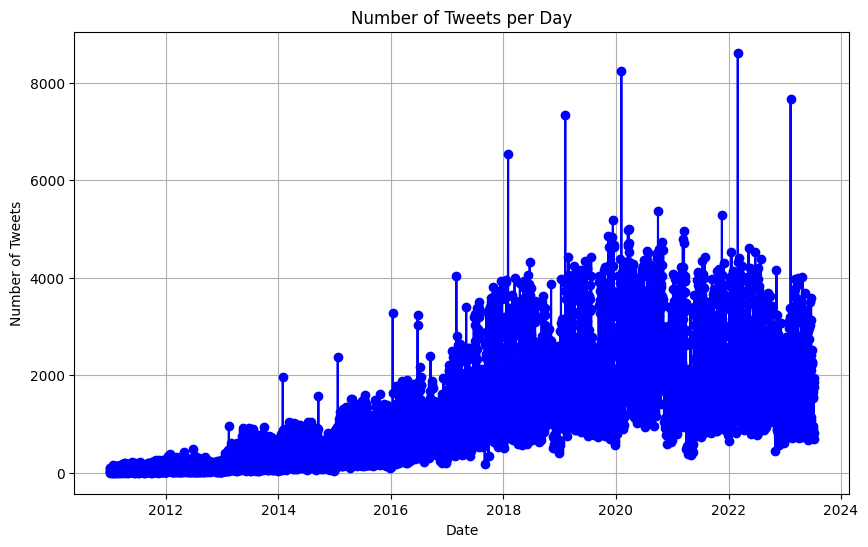

In [ ]:
#Visualizing tweets over time
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

tweet_counts = df_tweets.groupby('date').size()  # Count tweets per day

plt.figure(figsize=(10,6))
plt.plot(tweet_counts.index, tweet_counts.values, marker='o', linestyle='-', color='b')

plt.title('Number of Tweets per Day')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()

### Topic Modelling

#### BERTopic on Issue Data

In [3]:
df_issue_final = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/df_issue_final.csv')

In [4]:
df_issue_final = df_issue_final.drop('BERTTopic',axis=1)

In [6]:
# Drop NA and reset index to ensure clean list of documents
issue_documents = df_issue_final['PreprocessedIssue'].dropna().reset_index(drop=True).tolist()

# Initialize the sentence transformer embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Track embedding progress
print(f'Generating embeddings for {len(issue_documents)} documents...')
embeddings = embedding_model.encode(issue_documents, show_progress_bar=True, batch_size=32)

# Configure HDBSCAN for clustering to limit topic count
hdbscan_model = HDBSCAN(
    min_cluster_size=1000,  # minimum number of documents within each topic. --> increased from 100 to 1000, to get less overlapping topics (diversity score was intitially low)
    min_samples=15, # increased from 5 to 10 to get fewer, stronger topics. 
    metric='euclidean',   # metric used for clustering
    prediction_data=True)

# Initialize BERTopic with the custom HDBSCAN model
topic_model = BERTopic(
    language='english',
    verbose=True,
    hdbscan_model=hdbscan_model)

# Fit BERTopic model using precomputed embeddings
print('Fitting BERTopic model...')
topics, probs = topic_model.fit_transform(issue_documents, embeddings)

# Save topic assignments back into DataFrame
df_issue_final.loc[df_issue_final['PreprocessedIssue'].notna(), 'BERTopic'] = topics

Generating embeddings for 420706 documents...


Batches: 100%|██████████| 13148/13148 [08:54<00:00, 24.62it/s]
2025-04-27 14:30:42,309 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Fitting BERTopic model...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-04-27 18:44:56,304 - BERTopic - Dimensionality - Completed ✓
2025-04-27 18:44:56,337 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, y

In [7]:
df_issue_final.to_csv('df_issue_final_revised_topics.csv',index=False)

In [8]:
bert_issue_topic_info = topic_model.get_topic_info()

In [9]:
bert_issue_topic_info.to_csv('bert_issue_topic_info',index=False)

In [10]:
#extracting information about top words for each topic. 
bert_issue_topics_dict = topic_model.get_topics()
bert_issue_topic_words = []

for topic_num, words in bert_issue_topics_dict.items():
    bert_issue_topic_words.append({
        'Topic': topic_num,
        'Words': ', '.join([word for word, _ in words])
    })
df_topic_words = pd.DataFrame(bert_issue_topic_words)

In [11]:
df_topic_words.to_csv('bert_topic_words.csv',index=False)

### LDA on Specific Issue

In [43]:
texts = df_issue_final['PreprocessedIssue'].dropna().tolist()

# Split preprocessed text into tokens
tokenized_texts = [text.split() for text in texts]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(tokenized_texts)

# Filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.5) # no words that appear in less than 5 documents, or more than 50%

# Create a bag-of-words representation for each document
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Train the LDA model
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10, # 10 unique topics
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Print the topics and their top keywords
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic {idx}: {topic}')

# Assign the dominant topic to each document
def get_dominant_topic(bow):
    topic_probs = lda_model.get_document_topics(bow)
    if topic_probs:
        return max(topic_probs, key=lambda x: x[1])[0]
    return -1

# Apply to corpus
df_issue_final.loc[df_issue_final['PreprocessedIssue'].notna(), 'LDATopic'] = [
    get_dominant_topic(bow) for bow in corpus
]

Topic 0: 0.134*"medicare" + 0.054*"medicaid" + 0.046*"payment" + 0.031*"hospital" + 0.023*"program" + 0.022*"physician" + 0.022*"reimbursement" + 0.020*"coverage" + 0.014*"part" + 0.014*"access"
Topic 1: 0.077*"support" + 0.015*"provide" + 0.014*"service" + 0.013*"increase" + 0.013*"advocate" + 0.013*"use" + 0.013*"house" + 0.011*"senate" + 0.011*"program" + 0.010*"include"
Topic 2: 0.157*"act" + 0.104*"health" + 0.059*"care" + 0.021*"access" + 0.017*"implementation" + 0.016*"public" + 0.014*"patient" + 0.013*"mental" + 0.012*"protection" + 0.012*"affordable"
Topic 3: 0.106*"act" + 0.058*"appropriations" + 0.055*"research" + 0.031*"consolidated" + 0.025*"development" + 0.025*"science" + 0.023*"national" + 0.018*"related" + 0.017*"innovation" + 0.016*"technology"
Topic 4: 0.184*"legislation" + 0.079*"monitor" + 0.041*"regulation" + 0.035*"federal" + 0.025*"specific" + 0.023*"lobby" + 0.022*"activity" + 0.020*"privacy" + 0.018*"administrative" + 0.017*"action"
Topic 5: 0.104*"funding" + 

In [45]:
# Extract topic keywords into a list of dictionaries
topics_list = []
for topic_id, topic in lda_model.show_topics(num_topics=-1, num_words=10, formatted=False):
    for rank, (word, weight) in enumerate(topic):
        topics_list.append({
            'Topic': topic_id,
            'Rank': rank + 1,
            'Word': word,
            'Weight': weight
        })

# Convert to DataFrame
df_lda_topics = pd.DataFrame(topics_list)

#### BERTopic on Tweets

In [13]:
df_tweets = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/progress/tweets_processed.csv',dtype={'id':str,'user_id':str})

In [15]:
# Build topic dictionary
top_n = 10
topic_keywords = df_topic_words.groupby('Topic').agg(
    top_words=('Words', lambda x: ' '.join(x.iloc[:top_n]))
).to_dict()['top_words']

# Load embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Prepare topic embeddings
topic_ids = list(topic_keywords.keys())
topic_sentences = [topic_keywords[tid] for tid in topic_ids]
topic_embeddings = model.encode(topic_sentences, convert_to_tensor=False)

# Batched tweet encoding and similarity scoring
def batched_topic_match(texts, batch_size=500):
    all_matched_topics = []
    all_scores = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        batch_embeddings = model.encode(batch, convert_to_tensor=False)
        sim_matrix = cosine_similarity(batch_embeddings, topic_embeddings)

        best_indices = np.argmax(sim_matrix, axis=1)
        best_scores = np.max(sim_matrix, axis=1)
        matched_ids = [topic_ids[idx] for idx in best_indices]

        all_matched_topics.extend(matched_ids)
        all_scores.extend(best_scores)

    return all_matched_topics, all_scores

# Run the batched matching
tweet_texts = df_tweets['preprocessed_text'].fillna('').tolist()
df_tweets['BERTopic'], df_tweets['Topic_Similarity'] = batched_topic_match(tweet_texts)

100%|██████████| 13290/13290 [2:27:20<00:00,  1.50it/s]  


In [16]:
df_tweets = df_tweets[df_tweets['Topic_Similarity']>=0.45] # only keep tweets with over 0.5 topic similarity to one of the topics created from specific issue
df_tweets = df_tweets[df_tweets['BERTopic'].map(df_tweets['BERTopic'].value_counts()) >= 1000] # only keep topics with more than 100 tweets belonging to them

In [17]:
df_tweets.to_csv('df_tweets_final_topics_revised.csv',index=False)

### LDA on Tweets

In [51]:
# Tokenize tweets
tokenized_tweets = [text.split() for text in df_tweets['preprocessed_text']]

# Convert to BoW using the same dictionary from LDA model
tweet_corpus = [dictionary.doc2bow(text) for text in tokenized_tweets]

# Function to get dominant topic and score
def get_topic_with_score(bow):
    topic_probs = lda_model.get_document_topics(bow)
    if topic_probs:
        dominant_topic, score = max(topic_probs, key=lambda x: x[1])
        return dominant_topic, score
    return -1, 0.0

# Batching setup
batch_size = 64
dominant_topics = []
topic_scores = []

print(f'Processing {len(tweet_corpus)} tweets in batches of {batch_size}...')

for i in tqdm(range(0, len(tweet_corpus), batch_size)):
    batch = tweet_corpus[i:i + batch_size]
    for bow in batch:
        topic, score = get_topic_with_score(bow)
        dominant_topics.append(topic)
        topic_scores.append(score)

# Store in DataFrame
df_tweets['LDA_Topic'] = dominant_topics
df_tweets['Topic_Score'] = topic_scores


Processing 193273 tweets in batches of 64...


100%|██████████| 3020/3020 [00:16<00:00, 188.66it/s]


### Sentiment Analysis with VADER

In [35]:
#initiate model
analyzer = SentimentIntensityAnalyzer()

# Function to apply VADER sentiment analysis
def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

#df_tweets['VADER_Compound'] = df_tweets['preprocessed_text'].fillna('').apply(get_vader_sentiment)


### Sentiment Analysis with twitter-roberta-base-sentiment

In [23]:
n = len(df_tweets)
quarter = n // 4  # Integer division

df_tweets_q1 = df_tweets.iloc[:quarter]
df_tweets_q2 = df_tweets.iloc[quarter:2*quarter]
df_tweets_q3 = df_tweets.iloc[2*quarter:3*quarter]
df_tweets_q4 = df_tweets.iloc[3*quarter:]


In [ ]:
# Load the tokenizer and model from Hugging Face
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create sentiment pipeline
device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=device)

# Prepare tweet text
texts = df_tweets_q1['preprocessed_text'].fillna('').tolist()

# Batched inference to avoid memory issues
batch_size = 64
labels = []
scores = []

print(f'Applying RoBERTa sentiment model to {len(texts)} tweets...')

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    results = sentiment_pipeline(batch)
    for result in results:
        labels.append(result['label'])
        scores.append(result['score'])

# Add results to DataFrame
df_tweets_q1['RoBERTa_Label'] = labels
df_tweets_q1['RoBERTa_Score'] = scores

/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Applying RoBERTa sentiment model to 180562 tweets...


100%|██████████| 2822/2822 [2:10:59<00:00,  2.79s/it]  
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/698936174.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q1["RoBERTa_Label"] = labels
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/698936174.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q1["RoBERTa_Score"] = scores


In [ ]:
# Prepare tweet text
texts = df_tweets_q2['preprocessed_text'].fillna('').tolist()

# Batched inference to avoid memory issues
batch_size = 64
labels = []
scores = []

print(f'Applying RoBERTa sentiment model to {len(texts)} tweets...')

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    results = sentiment_pipeline(batch)
    for result in results:
        labels.append(result['label'])
        scores.append(result['score'])

# Add results to DataFrame
df_tweets_q2['RoBERTa_Label'] = labels
df_tweets_q2['RoBERTa_Score'] = scores

Applying RoBERTa sentiment model to 180562 tweets...


100%|██████████| 2822/2822 [2:08:51<00:00,  2.74s/it]  
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/2497617068.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q2["RoBERTa_Label"] = labels
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/2497617068.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q2["RoBERTa_Score"] = scores


In [ ]:
# Prepare tweet text
texts = df_tweets_q3['preprocessed_text'].fillna('').tolist()

# Batched inference to avoid memory issues
batch_size = 64
labels = []
scores = []

print(f'Applying RoBERTa sentiment model to {len(texts)} tweets...')

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    results = sentiment_pipeline(batch)
    for result in results:
        labels.append(result['label'])
        scores.append(result['score'])

# Add results to DataFrame
df_tweets_q3['RoBERTa_Label'] = labels
df_tweets_q3['RoBERTa_Score'] = scores

Applying RoBERTa sentiment model to 180562 tweets...


100%|██████████| 2822/2822 [2:04:53<00:00,  2.66s/it]  
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/3953782709.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q3["RoBERTa_Label"] = labels
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/3953782709.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q3["RoBERTa_Score"] = scores


In [ ]:
# Prepare tweet text
texts = df_tweets_q4['preprocessed_text'].fillna('').tolist()

# Batched inference to avoid memory issues
batch_size = 64
labels = []
scores = []

print(f'Applying RoBERTa sentiment model to {len(texts)} tweets...')

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    results = sentiment_pipeline(batch)
    for result in results:
        labels.append(result['label'])
        scores.append(result['score'])

# Add results to DataFrame
df_tweets_q4['RoBERTa_Label'] = labels
df_tweets_q4['RoBERTa_Score'] = scores

Applying RoBERTa sentiment model to 180562 tweets...


100%|██████████| 2822/2822 [2:14:42<00:00,  2.86s/it]   
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/326269154.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q4["RoBERTa_Label"] = labels
/var/folders/pg/ghgx2xgn3qb65km4qhtfgzhr0000gn/T/ipykernel_91790/326269154.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_q4["RoBERTa_Score"] = scores


In [ ]:
df_tweets = pd.concat([df_tweets_q1, df_tweets_q2, df_tweets_q3, df_tweets_q4])
df_tweets.reset_index(drop=True, inplace=True)

In [78]:
#counting number of words used analysis
#all_text_tweets_processed = ' '.join(df_tweets['preprocessed_text'].dropna())
#all_text_tweets_processed = all_text_tweets_processed.split()
total_word_count_tweets_processed = len(all_text_tweets_processed)

print(f'Number of words tweets: {total_word_count_tweets_processed}') 

Number of words tweets: 4766730


# Model Evaluation

In [ ]:
topics_info_bert = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/bert_topic_words.csv')

In [105]:
topics_info_lda = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/LDA_Topics.csv')

In [64]:
# Tokenize the preprocessed issue documents
tokenized_texts = [doc.split() for doc in issue_documents]

# Build Dictionary and Corpus (similar to your LDA preprocessing)
dictionary = corpora.Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Extract top words from BERTopic
topics = topic_model.get_topics()

# Prepare list of top 10 words per topic (excluding outlier topic -1)
top_words = []
for topic_id, words in topics.items():
    if topic_id == -1:
        continue  # skip outliers
    topic_keywords = [word for word, _ in words[:10]]  # take top 10 words
    top_words.append(topic_keywords)

# Calculate the Coherence Score
coherence_model_bertopic = CoherenceModel(
    topics=top_words,
    texts=tokenized_texts,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_bertopic = coherence_model_bertopic.get_coherence()

print(f'Coherence Score for BERTopic: {coherence_bertopic:.4f}')

/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports Ope

Coherence Score for BERTopic: 0.5815


In [22]:
# Exclude the outlier topic (-1)
df_valid_topics_bert = df_topic_words[df_topic_words['Topic'] != -1]

# Split the 'Words' strings into lists
df_valid_topics_bert['Words'] = df_valid_topics_bert['Words'].apply(lambda x: [word.strip() for word in x.split(',')])

# Flatten all the words into one big list
all_top_words_bert = [word for words_list in df_valid_topics_bert['Words'] for word in words_list]

# Calculate diversity
unique_words_bert = set(all_top_words_bert)
diversity_score_bert = len(unique_words_bert) / len(all_top_words_bert)

# Print result
print(f'Diversity Score for BERTopic topics: {diversity_score_bert:.4f}') #


Diversity Score for BERTopic topics: 0.6857


In [63]:
# Corrected coherence calculation for LDA
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print(f'Coherence Score for LDA: {coherence_lda:.4f}')

/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kristianmadslangrud/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports Ope

Coherence Score for LDA: 0.5288


In [ ]:
# Collect all words across all topics
all_lda_top_words = df_lda_topics['Word'].tolist()

# Calculate diversity
unique_lda_words = set(all_lda_top_words)
diversity_score_lda = len(unique_lda_words) / len(all_lda_top_words)

print(f'Diversity Score for LDA topics: {diversity_score_lda:.4f}')

Diversity Score for LDA topics: 0.8700


In [ ]:
# Sample a random subset of tweets
subset_size = 10000
subset_indices = np.random.choice(df_tweets.index, size=subset_size, replace=False)

# Re-run VADER only on this subset
df_tweets.loc[subset_indices, 'VADER_Compound_New'] = df_tweets.loc[subset_indices, 'preprocessed_text'].fillna('').apply(get_vader_sentiment)

# Compare old vs new for the subset
inconsistencies_vader = (df_tweets.loc[subset_indices, 'VADER_Compound'] != df_tweets.loc[subset_indices, 'VADER_Compound_New'])

# Summarize
print(f'Number of inconsistent VADER predictions (on subset): {inconsistencies_vader.sum()}')

# View inconsistencies
print(df_tweets.loc[subset_indices[inconsistencies_vader], ['preprocessed_text', 'VADER_Compound', 'VADER_Compound_New']])

Number of inconsistent VADER predictions (on subset): 0
Empty DataFrame
Columns: [preprocessed_text, VADER_Compound, VADER_Compound_New]
Index: []


In [56]:
# Sample a random subset of tweets
subset_indices = np.random.choice(df_tweets.index, size=subset_size, replace=False)

# Prepare texts from the subset
texts = df_tweets.loc[subset_indices, 'preprocessed_text'].fillna('').tolist()

# Re-run RoBERTa on the subset
batch_size = 64
new_labels = []
new_scores = []

print(f'Re-running RoBERTa model on a subset of {len(texts)} tweets...')

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    results = sentiment_pipeline(batch)
    for result in results:
        new_labels.append(result['label'])
        new_scores.append(result['score'])

# Save predictions only for the subset
df_tweets.loc[subset_indices, 'RoBERTa_Label_New'] = new_labels
df_tweets.loc[subset_indices, 'RoBERTa_Score_New'] = new_scores

# Compare old vs new for the subset
label_inconsistencies = df_tweets.loc[subset_indices, 'RoBERTa_Label'] != df_tweets.loc[subset_indices, 'RoBERTa_Label_New']
score_inconsistencies = (df_tweets.loc[subset_indices, 'RoBERTa_Score'] - df_tweets.loc[subset_indices, 'RoBERTa_Score_New']).abs() > 1e-6

# Summarize
print(f'Number of inconsistent RoBERTa labels (on subset): {label_inconsistencies.sum()}')
print(f'Number of inconsistent RoBERTa scores (on subset): {score_inconsistencies.sum()}')

# View inconsistencies
print(df_tweets.loc[subset_indices[label_inconsistencies | score_inconsistencies], 
                    ['preprocessed_text', 'RoBERTa_Label', 'RoBERTa_Label_New', 'RoBERTa_Score', 'RoBERTa_Score_New']])


Re-running RoBERTa model on a subset of 10000 tweets...


100%|██████████| 157/157 [06:01<00:00,  2.30s/it]


Number of inconsistent RoBERTa labels (on subset): 0
Number of inconsistent RoBERTa scores (on subset): 0
Empty DataFrame
Columns: [preprocessed_text, RoBERTa_Label, RoBERTa_Label_New, RoBERTa_Score, RoBERTa_Score_New]
Index: []


In [58]:
df_tweets.drop(['VADER_Compound_New','RoBERTa_Label_New','RoBERTa_Score_New'],axis=1)

,id,screen_name,user_id,text,date,preprocessed_text,BERTopic,Topic_Similarity,VADER_Compound,RoBERTa_Label,RoBERTa_Score,LDA_Topic,Topic_Score
0,22413036140630016,chelliepingree,14984637,"First ""whip question"" of new Congress, How wil...",2011-01-04,first whip question new congress vote republic...,-1,0.529176,-0.0772,LABEL_0,0.552683,1,0.390291
1,22822835290374145,RobWittman,15356407,Tomorrow we will read the Constitution authore...,2011-01-06,tomorrow read constitution author founding fat...,15,0.451036,0.0000,LABEL_1,0.891566,6,0.560234
2,25928622896324608,DrPhilRoe,52503751,After Obamacare: Principles for reform @washti...,2011-01-14,obamacare principle reform,15,0.498813,0.0000,LABEL_1,0.821345,2,0.303394
3,27436600031973376,RepHanabusa,235373000,AARP Letter to Congress: Repeal of Health Law ...,2011-01-18,aarp letter congress repeal health law would e...,15,0.469746,0.4767,LABEL_1,0.514958,1,0.366381
4,27479021482680320,Robert_Aderholt,76452765,The healthcare law is the prime example of how...,2011-01-18,healthcare law prime example washington democr...,-1,0.532591,0.0000,LABEL_1,0.642210,2,0.283049
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193268,1057326751926366209,RepDougCollins,1060487274,Fifth-graders at Mt. Vernon Elementary greeted...,2018-10-30,fifth grader vernon elementary greet great que...,15,0.497831,0.9485,LABEL_2,0.809029,1,0.340773
193269,1057332835864973312,RepEBJ,168502762,This is unconstitutional. Pres. Trump cannot t...,2018-10-30,unconstitutional pre trump take away birthrigh...,15,0.535543,0.7351,LABEL_0,0.583233,6,0.275665
193270,1057248717319954433,elizabethforma,357606935,"As Sec of @HHSgov for President Clinton, @Donn...",2018-10-30,sec president clinton key part team push assau...,13,0.473249,-0.8720,LABEL_0,0.498349,1,0.320428
193271,1057313859697041409,NitaLowey,221792092,"For more than a century, crossing Republican a...",2018-10-30,century cross republican democratic administra...,15,0.458550,0.6249,LABEL_1,0.812413,6,0.198512


# NLP Analysis

#### Merging Processed Tweet Dataset with Sponsor dataset

In [26]:
df_tweets = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/df_tweets_final_topics_revised.csv',dtype={'id':str,'user_id':str})
df_bills_final = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/df_bills_final.csv',dtype={'user_id':str})
df_lobbying = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/df_lobbying_final.csv')
df_master_table = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/df_master_table.csv')
df_issue_final = pd.read_csv('/Users/kristianmadslangrud/Desktop/thesis_data/df_issue_final_revised_topics.csv')

In [13]:
df_sponsor_match = load_csv(sponsor_tweet_match,save_file=False)
df_sponsor_match.columns = ['raw_name','matched_name','screen_name','user_id','acc_type']
df_sponsor_match = df_sponsor_match.iloc[1:] # dropping first row of dataframe


Downloading...
From: https://drive.google.com/uc?export=download&id=1jlP28xifZx74RkWLhVPAEqooH11Ak6mA
To: /Users/kristianmadslangrud/Documents/GitHub/master_thesis25/sponsor_matches.csv
100%|██████████| 81.9k/81.9k [00:00<00:00, 58.4MB/s]


In [ ]:
# Merge sponsor user_id into bill data
df_bills_final = df_bills_final.merge(
    df_sponsor_match[['raw_name', 'user_id']],
    how='left',
    left_on='SponsorName',
    right_on='raw_name'
)

# Create party lookup table (unique user_id to SponsorParty mapping)
df_party_lookup = (
    df_bills_final[['user_id', 'SponsorParty']]
    .dropna()
    .drop_duplicates(subset='user_id')
    .reset_index(drop=True)
)

# Merge party info into tweets using the party lookup
df_tweets = df_tweets.merge(
    df_party_lookup,
    how='left',
    on='user_id'
)

## Topic Modelling Analysis

#### Lobbying by BERTopic

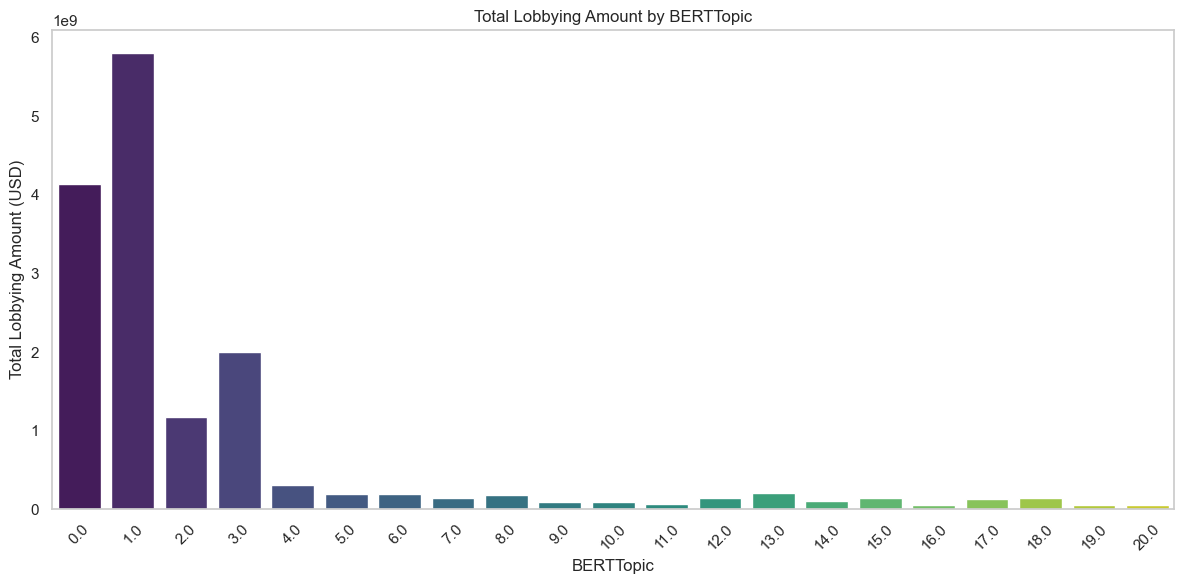

In [109]:
# Merge Fact Table with Lobbying Report to get 'Amount' and 'SI_ID'
fact_reports = df_master_table.merge(df_lobbying, on='UniqID', how='left')

# Merge with Issue table to get BERTopic
fact_reports_with_topics_bert = fact_reports.merge(df_issue_final[['SI_ID', 'BERTopic']], on='SI_ID', how='left')

# Exclude topics labeled as -1 (outliers)
fact_reports_with_topics_bert = fact_reports_with_topics_bert[fact_reports_with_topics_bert['BERTopic'] != -1]

# Remove duplicate UniqID entries to ensure each lobbying amount is counted only once
fact_reports_unique = fact_reports_with_topics_bert.drop_duplicates(subset=['UniqID'])

# Now group by BERTopic and sum the lobbying Amount
topic_lobbying_amount_bert = (
    fact_reports_unique.groupby('BERTopic')['Amount']
    .sum()
    .reset_index()
    .rename(columns={'Amount': 'Total_Lobbying_Amount'})
    .sort_values(by='Total_Lobbying_Amount', ascending=False)
)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=topic_lobbying_amount_bert, x='BERTopic', y='Total_Lobbying_Amount', palette='viridis')
plt.title('Total Lobbying Amount by BERTTopic')
plt.xlabel('BERTTopic')
plt.ylabel('Total Lobbying Amount (USD)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



#### Tweets by BERTopic

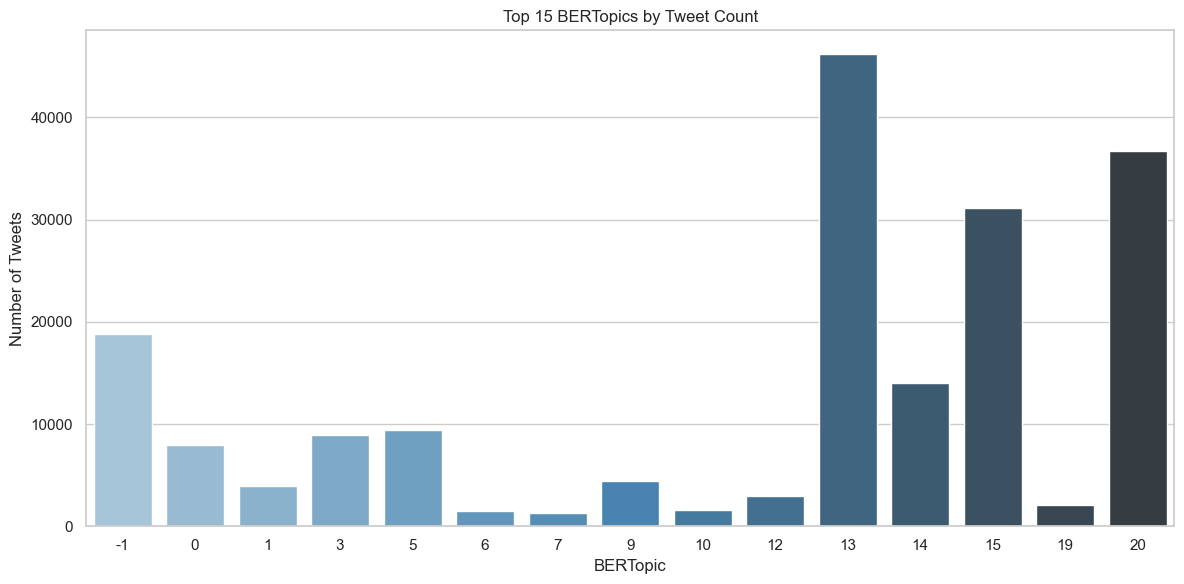

In [100]:
topic_count_bert = df_tweets.groupby('BERTopic').size()

# Convert the Series to a DataFrame and rename columns
topic_count_bert_df = topic_count_bert.reset_index(name='Tweet_Count')

# Ensure BERTopic is an integer (or string, if for plotting)
topic_count_bert_df['BERTopic'] = topic_count_bert_df['BERTopic'].astype(int)
topic_count_bert_df = topic_count_bert_df.sort_values('Tweet_Count',ascending=False)


# filter for most used topics
top_n = 15
top_topics_bert_df = topic_count_bert_df.head(top_n)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_topics_bert_df, x='BERTopic', y='Tweet_Count', palette='Blues_d')
plt.title(f'Top {top_n} BERTopics by Tweet Count')
plt.xlabel('BERTopic')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()

#### Tweets by LDA

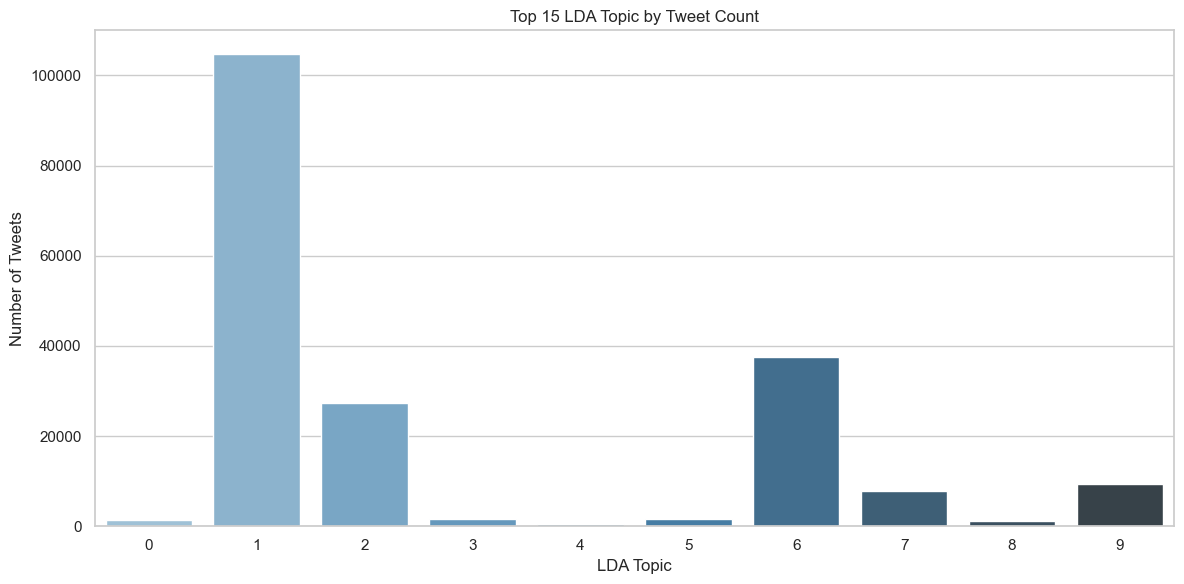

In [101]:
topic_count_lda = df_tweets.groupby('LDA_Topic').size()

# Convert the Series to a DataFrame and rename columns
topic_count_lda_df = topic_count_lda.reset_index(name='Tweet_Count')

# Ensure BERTopic is an integer (or string, if for plotting)
topic_count_lda_df['LDA_Topic'] = topic_count_lda_df['LDA_Topic'].astype(int)
topic_count_lda_df = topic_count_lda_df.sort_values('Tweet_Count',ascending=False)


# filter for most used topics
top_n = 15
top_topics_lda_df = topic_count_lda_df.head(top_n)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_topics_lda_df, x='LDA_Topic', y='Tweet_Count', palette='Blues_d')
plt.title(f'Top {top_n} LDA Topic by Tweet Count')
plt.xlabel('LDA Topic')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()

## Temporal Sentiment Analysis

#### VADER

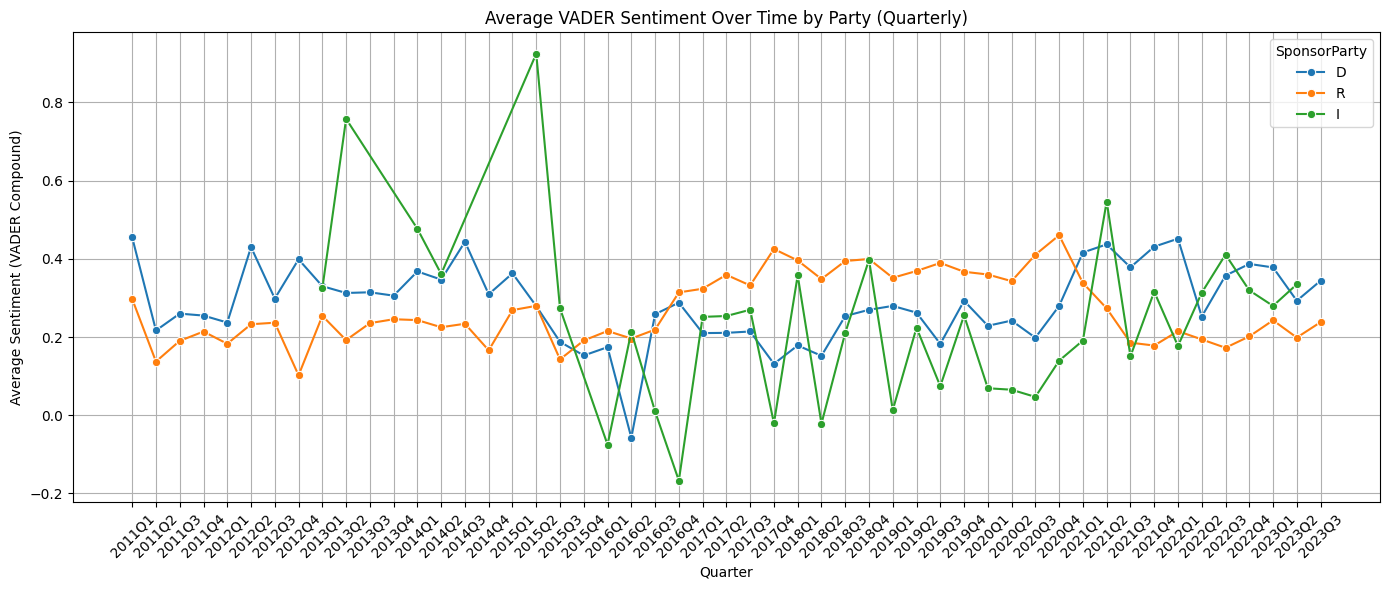

In [30]:
# Creating Quarter column
df_tweets['date'] = pd.to_datetime(df_tweets['date'])
df_tweets['Quarter'] = df_tweets['date'].dt.to_period('Q')

# Aggregate sentiment by quarter and party
sentiment_by_quarter_party = df_tweets.groupby(['Quarter', 'SponsorParty'])['VADER_Compound'].mean().reset_index()
sentiment_by_quarter_party['Quarter'] = sentiment_by_quarter_party['Quarter'].astype(str)

# Plot average sentiment over time (by quarter) by party
plt.figure(figsize=(14, 6))
sns.lineplot(data=sentiment_by_quarter_party, x='Quarter', y='VADER_Compound', hue='SponsorParty', marker='o')
plt.title('Average VADER Sentiment Over Time by Party (Quarterly)')
plt.ylabel('Average Sentiment (VADER Compound)')
plt.xlabel('Quarter')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

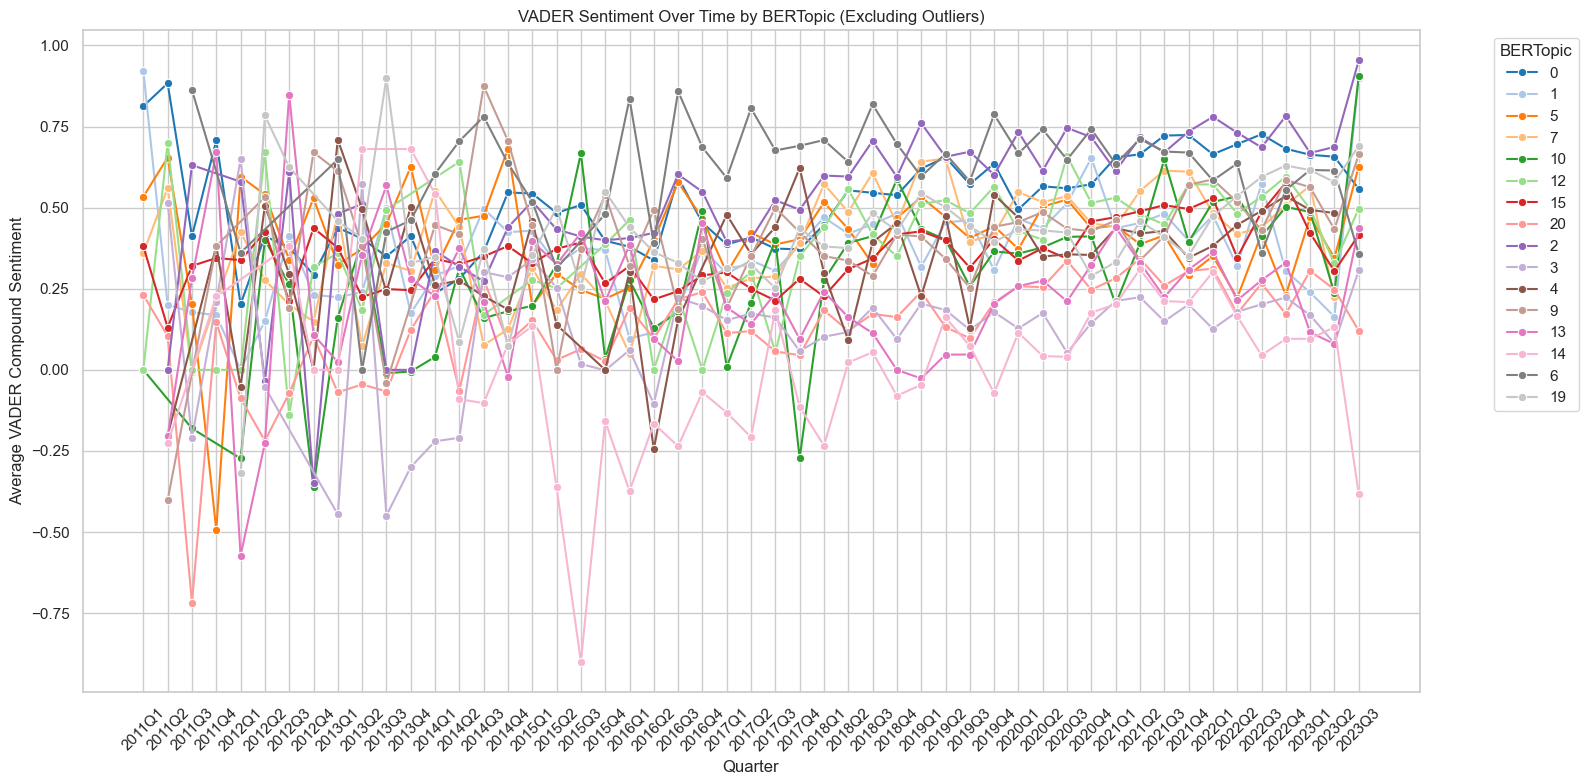

In [151]:
# Group by Quarter and BERTopic and calculate average VADER sentiment
sentiment_over_time = (
    df_tweets_filtered.groupby(['Quarter', 'BERTopic'])['VADER_Compound']
    .mean()
    .reset_index()
)

# Convert Quarter to string for nicer plotting
sentiment_over_time['Quarter'] = sentiment_over_time['Quarter'].astype(str)
sentiment_over_time['BERTopic'] = sentiment_over_time['BERTopic'].astype(int).astype(str)

# Create a color palette
num_topics = sentiment_over_time['BERTopic'].nunique()
palette = sns.color_palette('tab20', n_colors=num_topics)

# Plot
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=sentiment_over_time,
    x='Quarter',
    y='VADER_Compound',
    hue='BERTopic',
    marker='o',
    palette=palette
)

plt.title('VADER Sentiment Over Time by BERTopic (Excluding Outliers)')
plt.xlabel('Quarter')
plt.ylabel('Average VADER Compound Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='BERTopic')
plt.tight_layout()
plt.show()

<Figure size 1600x700 with 0 Axes>

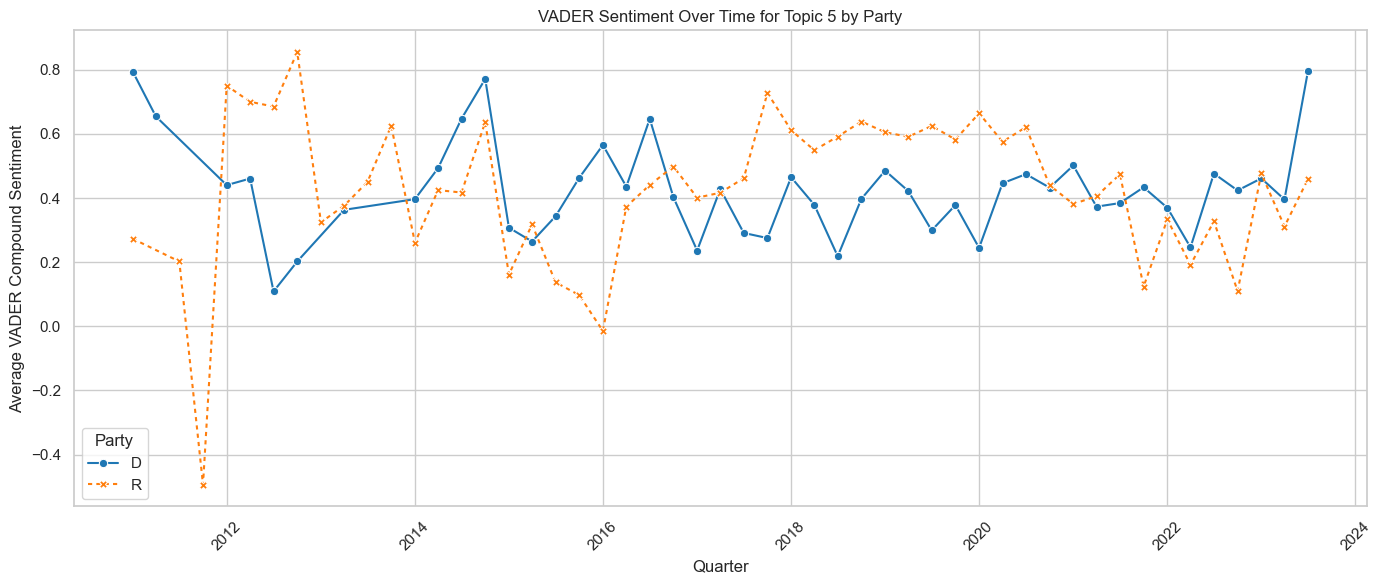

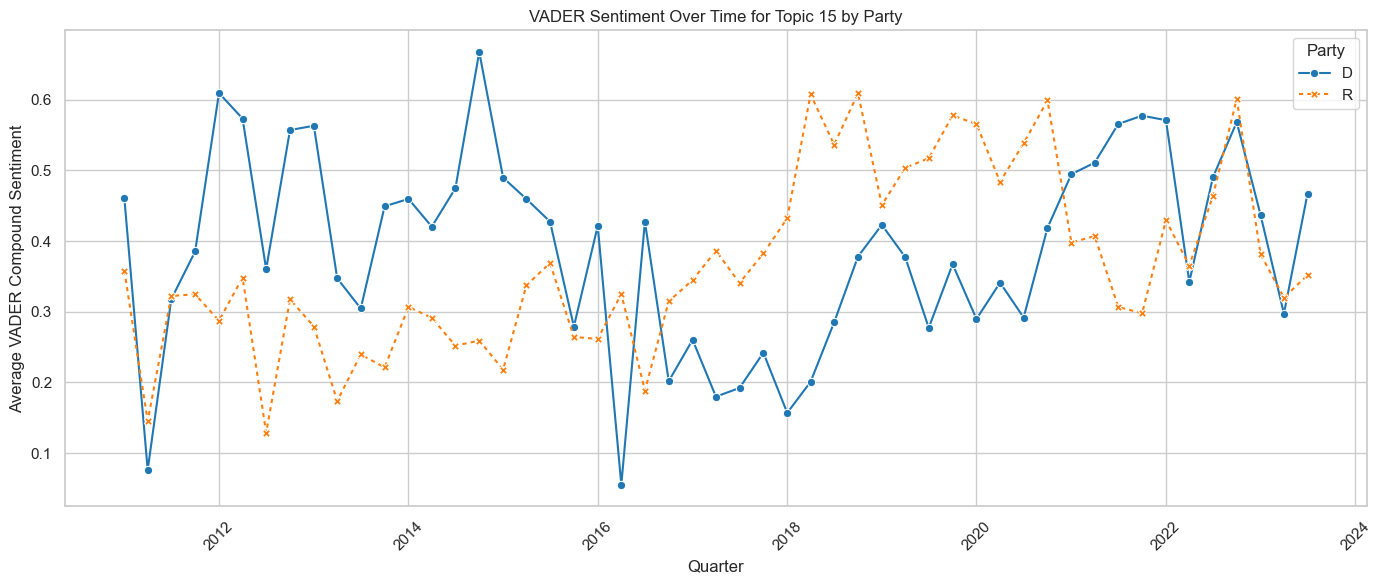

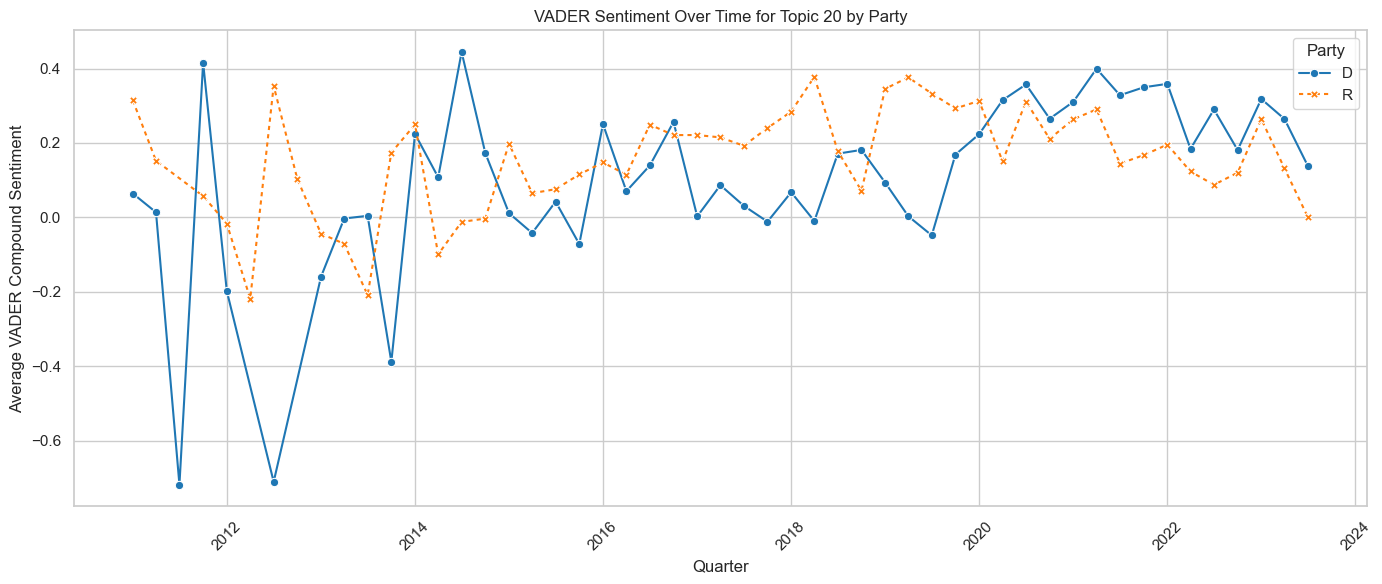

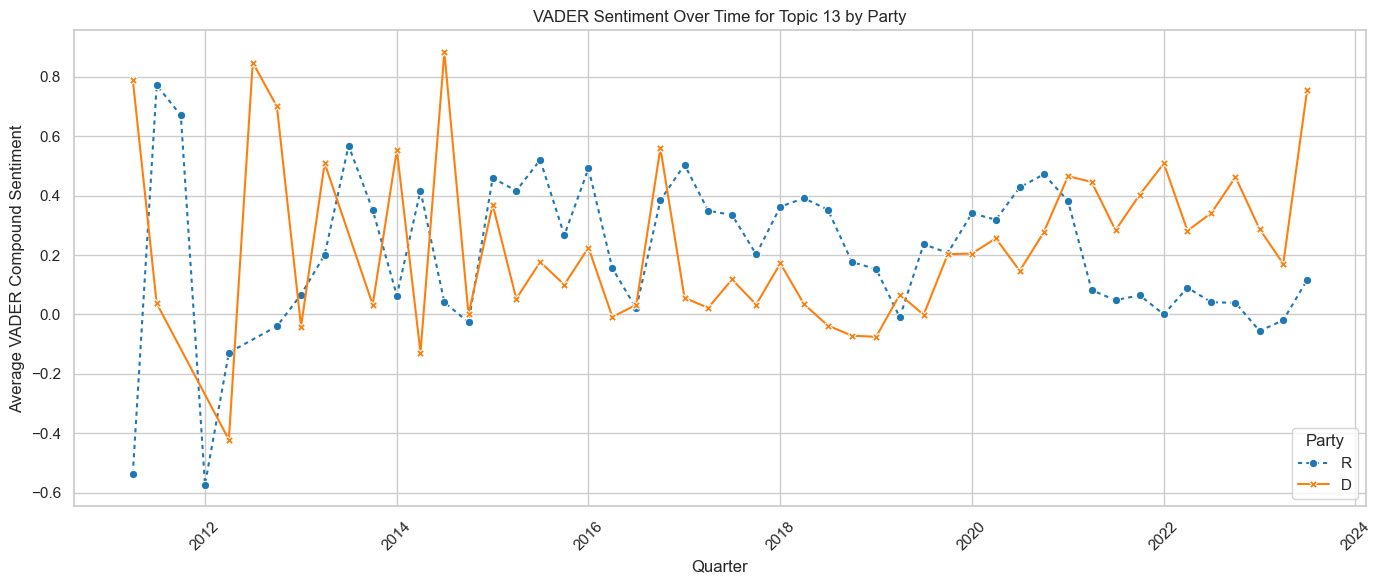

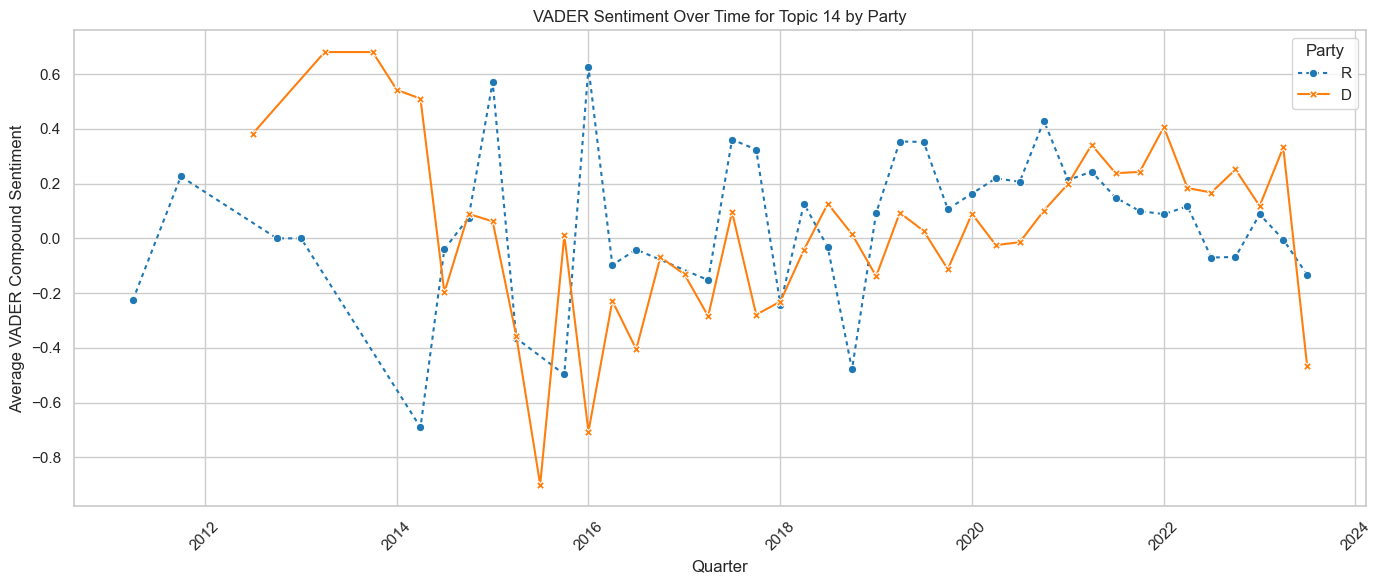

In [152]:
# Filter out outlier topic and "I" party
df_tweets_filtered = df_tweets[
    (df_tweets['BERTopic'] != -1) & 
    (df_tweets['SponsorParty'].isin(['R', 'D']))
]

# Calculate standard deviation of sentiment per topic
volatility_by_issue_bert = (
    df_tweets_filtered.groupby('BERTopic')['VADER_Compound']
    .std()
    .reset_index()
    .rename(columns={'VADER_Compound': 'Sentiment_STD'})
    .sort_values(by='Sentiment_STD', ascending=False)
)

# Select top 5 most volatile topics
top_volatile_issues_bert = volatility_by_issue_bert.head(5)['BERTopic'].tolist()

# Filter dataset to only those topics
volatile_bert_df = df_tweets_filtered[df_tweets_filtered['BERTopic'].isin(top_volatile_issues_bert)]

# Group by Quarter, Topic, and Party
issue_sentiment_trends_bert = (
    volatile_bert_df.groupby(['Quarter', 'BERTopic', 'SponsorParty'])['VADER_Compound']
    .mean()
    .reset_index()
)

# Convert quarter for better plotting
issue_sentiment_trends_bert['Quarter'] = pd.PeriodIndex(issue_sentiment_trends_bert['Quarter'], freq='Q').to_timestamp()

# Sort by datetime for plotting
issue_sentiment_trends_bert = issue_sentiment_trends_bert.sort_values(by='Quarter')

# Set up plot
plt.figure(figsize=(16, 7))


# Plot each of the top 5 volatile topics separately
for topic in issue_sentiment_trends_bert['BERTopic'].unique():
    subset = issue_sentiment_trends_bert[issue_sentiment_trends_bert['BERTopic'] == topic]
    plt.figure(figsize=(14, 6))
    sns.lineplot(
        data=subset,
        x='Quarter',
        y='VADER_Compound',
        hue='SponsorParty',
        style='SponsorParty',
        markers=True,
        dashes={'D': '', 'R': (2, 2)}
    )
    plt.title(f'VADER Sentiment Over Time for Topic {int(topic)} by Party')
    plt.ylabel('Average VADER Compound Sentiment')
    plt.xlabel('Quarter')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title='Party')
    plt.show()

#### roBERTa

In [ ]:
# Define sentiment label mapping
label_map = {'LABEL_0': 'negative','LABEL_1': 'neutral','LABEL_2': 'positive'}
label_to_num = {'LABEL_0': -1, 'LABEL_1': 0, 'LABEL_2': 1}
df_tweets['RoBERTa_Score_Num'] = df_tweets['RoBERTa_Label'].map(label_to_num)
df_tweets['RoBERTa_Sentiment'] = df_tweets['RoBERTa_Label'].map(label_map)

# Filter by confidence score threshold
confidence_threshold = 0.7
filtered_df = df_tweets[df_tweets['RoBERTa_Score'] >= confidence_threshold].copy()


df_tweets['Quarter'] = pd.PeriodIndex(df_tweets['Quarter'], freq='Q').to_timestamp()

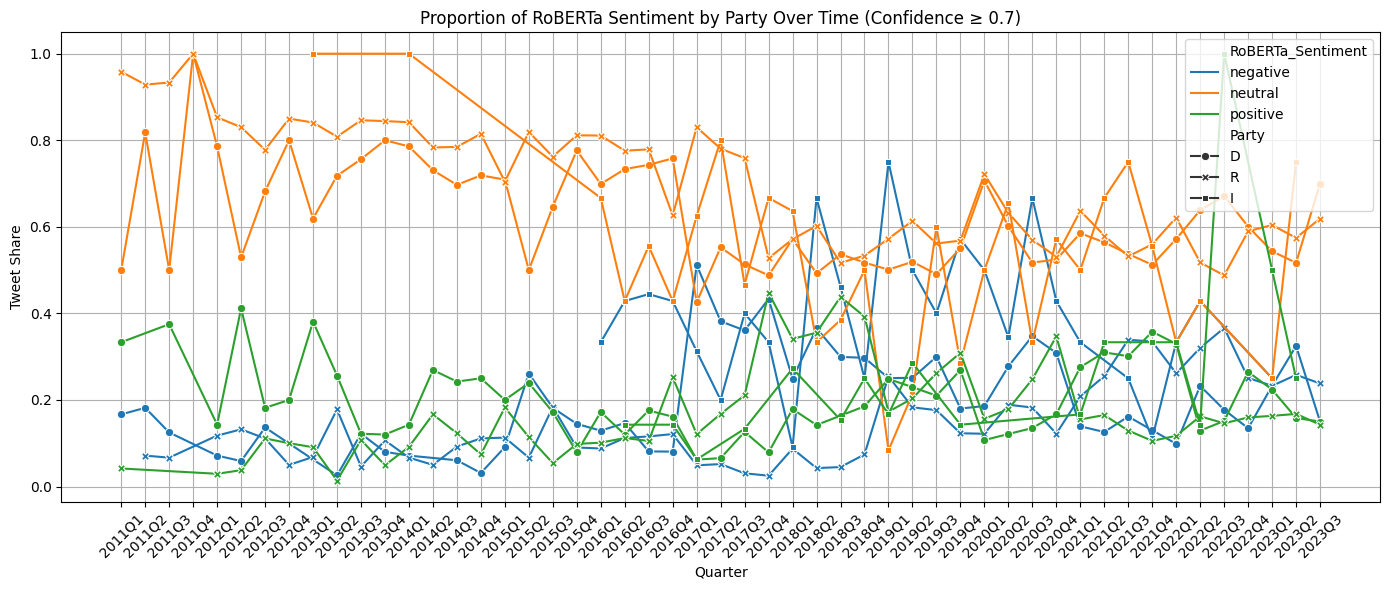

In [ ]:
# Group by quarter, party, sentiment
sentiment_counts = (
    filtered_df.groupby(['Quarter', 'SponsorParty', 'RoBERTa_Sentiment'])
    .size()
    .reset_index(name='Tweet_Count'))

# Calculate total tweets per party per quarter
total_counts = (
    sentiment_counts.groupby(['Quarter', 'SponsorParty'])['Tweet_Count']
    .sum()
    .reset_index(name='Total_Tweets'))

# Merge totals back into sentiment data
normalized_df = sentiment_counts.merge(total_counts, on=['Quarter', 'SponsorParty'])

# Compute proportion
normalized_df['Tweet_Share'] = normalized_df['Tweet_Count'] / normalized_df['Total_Tweets']

# Clean for plotting
normalized_df.rename(columns={'SponsorParty': 'Party'}, inplace=True)
normalized_df['Quarter'] = normalized_df['Quarter'].astype(str)

# Plot normalized tweet sentiment share
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=normalized_df,
    x='Quarter',
    y='Tweet_Share',
    hue='RoBERTa_Sentiment',
    style='Party',
    markers=True,
    dashes=False
)
plt.title(f'Proportion of RoBERTa Sentiment by Party Over Time (Confidence ≥ {confidence_threshold})')
plt.ylabel('Tweet Share')
plt.xlabel('Quarter')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


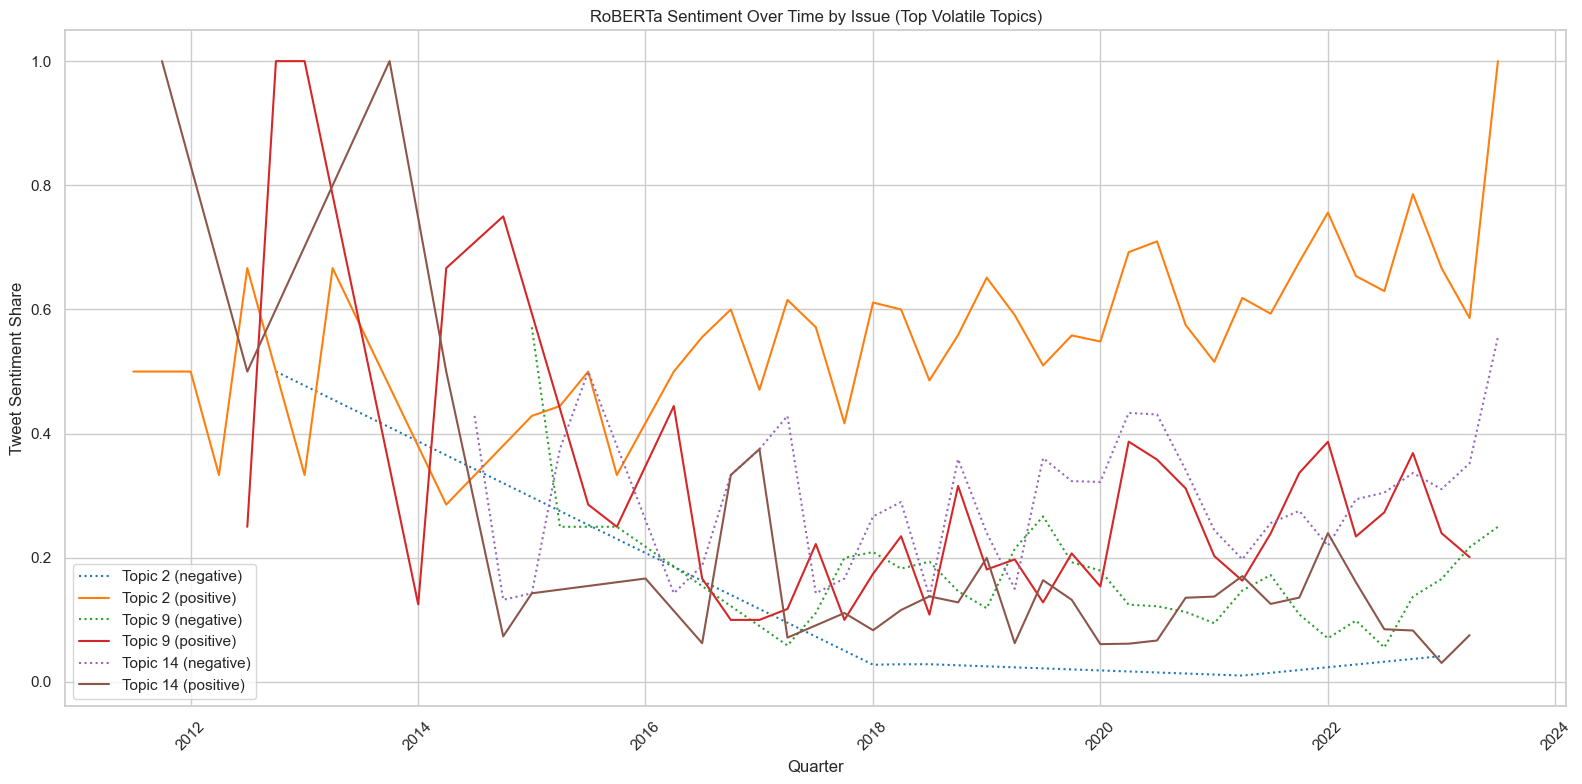

In [ ]:
# Calculate average numeric sentiment per topic over time
issue_sentiment_over_time_bert = (
    df_tweets.groupby(['BERTopic', 'Quarter'])['RoBERTa_Score_Num']
    .mean()
    .reset_index()
)

# Calculate sentiment volatility per topic
issue_volatility_bert = (
    issue_sentiment_over_time_bert.groupby('BERTopic')['RoBERTa_Score_Num']
    .std()
    .reset_index()
    .rename(columns={'RoBERTa_Score_Num': 'Sentiment_Volatility'})
    .sort_values(by='Sentiment_Volatility', ascending=False)
)

# Select top 10 volatile topics
top_volatile_issues_bert = issue_volatility_bert.head(3)['BERTopic'].tolist()

# Filter original data
volatile_bert_df = df_tweets[df_tweets['BERTopic'].isin(top_volatile_issues_bert)].copy()

# Group by topic, quarter, and sentiment
plot_data_bert = (
    volatile_bert_df.groupby(['BERTopic', 'Quarter', 'RoBERTa_Sentiment'])
    .size()
    .reset_index(name='Tweet_Count')
)

# Normalize
plot_data_bert['Total'] = plot_data_bert.groupby(['BERTopic', 'Quarter'])['Tweet_Count'].transform('sum')
plot_data_bert['Tweet_Share'] = plot_data_bert['Tweet_Count'] / plot_data_bert['Total']

# Filter to only positive and negative sentiments
plot_data_filtered = plot_data_bert[plot_data_bert['RoBERTa_Sentiment'].isin(['positive', 'negative'])].copy()

# Assign line styles: dotted for negative, solid for positive
plot_data_filtered['Line_Style'] = plot_data_filtered['RoBERTa_Sentiment'].map({
    'positive': 'solid',
    'negative': 'dotted'
})

# Plot
plt.figure(figsize=(16, 8))
for (topic, sentiment), data in plot_data_filtered.groupby(['BERTopic', 'RoBERTa_Sentiment']):
    linestyle = 'dotted' if sentiment == 'negative' else 'solid'
    plt.plot(data['Quarter'], data['Tweet_Share'], label=f'Topic {topic} ({sentiment})', linestyle=linestyle)

plt.title('RoBERTa Sentiment Over Time by Issue (Top Volatile Topics)')
plt.xlabel('Quarter')
plt.ylabel('Tweet Sentiment Share')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


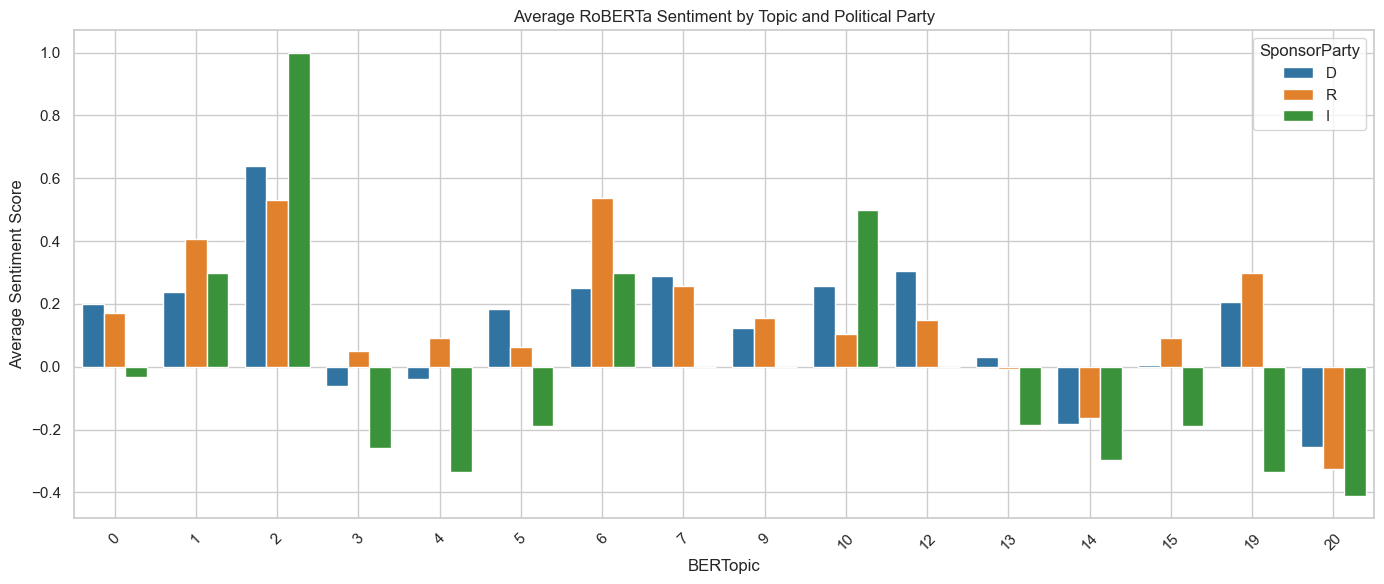

In [143]:
# Exclude outlier topic if needed
df_valid = df_tweets[df_tweets['BERTopic'] != -1]

# Group by topic and party to calculate average sentiment, std, and tweet count
sentiment_stats_by_topic_party = (
    df_valid.groupby(['BERTopic', 'SponsorParty'])['RoBERTa_Score_Num']
    .agg(
        Avg_Sentiment='mean',
        Sentiment_STD='std',
        Tweet_Count='count'
    )
    .reset_index()
    .sort_values(by='Avg_Sentiment', ascending=False)
)


plt.figure(figsize=(14, 6))
sns.barplot(
    data=sentiment_stats_by_topic_party,
    x='BERTopic',
    y='Avg_Sentiment',
    hue='SponsorParty'
)
plt.title('Average RoBERTa Sentiment by Topic and Political Party')
plt.ylabel('Average Sentiment Score')
plt.xlabel('BERTopic')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [144]:
# Top 5 most positive topics
most_positive = sentiment_stats_by_topic.head(5)

# Top 5 most negative topics
most_negative = sentiment_stats_by_topic.tail(5)

# Top 5 most volatile topics (by standard deviation)
most_volatile = sentiment_stats_by_topic.sort_values(by='Sentiment_STD', ascending=False).head(5)

# Display
print('Most Positive Topics:')
display(most_positive)

print('\nMost Negative Topics:')
display(most_negative)

print('\nMost Volatile Topics:')
display(most_volatile)

Most Positive Topics:


,BERTopic,Avg_Sentiment,Sentiment_STD,Tweet_Count
2,2,0.575419,0.505691,1074
6,6,0.373698,0.581751,1536
1,1,0.358447,0.581041,3942
7,7,0.282297,0.477813,1254
14,19,0.218504,0.542159,2032



Most Negative Topics:


,BERTopic,Avg_Sentiment,Sentiment_STD,Tweet_Count
4,4,-0.005420,0.486683,1107
11,13,-0.007444,0.606575,46209
3,3,-0.070107,0.517544,8972
12,14,-0.214479,0.620871,14020
15,20,-0.281465,0.551139,36708



Most Volatile Topics:


,BERTopic,Avg_Sentiment,Sentiment_STD,Tweet_Count
5,5,0.109559,0.670418,9447
13,15,0.020702,0.622574,31156
12,14,-0.214479,0.620871,14020
8,9,0.101055,0.618763,4453
11,13,-0.007444,0.606575,46209


### Comparing Sentiment by Topic With Lobbying Amounts

In [149]:
# Merge lobbying data with master table to get year
sentiment_analysis_across_topic_time= df_lobbying.merge(
    df_master_table[['UniqID', 'Year','SI_ID']],
    on='UniqID',
    how='left'
) # note: one UniqID can be related to several SI_ID. this makes the amount calculation slightly inaccurate. Skip repeating, SI_ID?

sentiment_analysis_across_topic_time = sentiment_analysis_across_topic_time[['UniqID','Amount','Quarter','Year','SI_ID']].drop_duplicates()
sentiment_analysis_across_topic_time

,UniqID,Amount,Quarter,Year,SI_ID
0,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909947
1,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909948
2,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909949
3,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909950
168,87ff989d-9d12-4fef-84ef-ab69cd616894,21650.0,Q4,2021,2909966
...,...,...,...,...,...
6495646,12a47a18-11f4-43b2-bb1f-3db51e07306b,20000.0,Q4,2022,3077176
6495650,0854dd96-ed91-4219-99d9-b84bf06ee2f8,440000.0,Q4,2022,3066813
6495651,0854dd96-ed91-4219-99d9-b84bf06ee2f8,440000.0,Q4,2022,3066814
6495668,b0235c16-0a34-4e06-be62-f42a3bf52d6a,80000.0,Q4,2022,3073031


In [153]:
# retrieving topics for each SI_ID
sentiment_analysis_across_topic_time = sentiment_analysis_across_topic_time.merge(
    df_issue_final[['SI_ID','BERTopic','LDATopic']],
    how='left',
    on = 'SI_ID'
)
sentiment_analysis_across_topic_time

# counting number of Specific Issues per UniqID
si_counts = sentiment_analysis_across_topic_time.groupby('UniqID')['SI_ID'].count().reset_index()
si_counts.columns = ['UniqID', 'SI_ID_Count']

sentiment_analysis_across_topic_time = sentiment_analysis_across_topic_time.merge(si_counts, on='UniqID', how='left')

# Distribute Amount across SI_IDs
sentiment_analysis_across_topic_time['Distributed_Amount'] = sentiment_analysis_across_topic_time['Amount'] / sentiment_analysis_across_topic_time['SI_ID_Count'] # number will not necessary be accurate for one SI_ID, but total for lobbying report. 

In [156]:
sentiment_analysis_across_topic_time

,UniqID,Amount,Quarter,Year,SI_ID,BERTopic,LDATopic,SI_ID_Count,Distributed_Amount
0,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909947,8.0,9.0,4,342500.0
1,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909948,17.0,9.0,4,342500.0
2,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909949,-1.0,6.0,4,342500.0
3,82c5f661-a637-45ad-a3a6-b5ba18cf8962,1370000.0,Q4,2021,2909950,-1.0,7.0,4,342500.0
4,87ff989d-9d12-4fef-84ef-ab69cd616894,21650.0,Q4,2021,2909966,-1.0,7.0,1,21650.0
...,...,...,...,...,...,...,...,...,...
381926,12a47a18-11f4-43b2-bb1f-3db51e07306b,20000.0,Q4,2022,3077176,-1.0,7.0,1,20000.0
381927,0854dd96-ed91-4219-99d9-b84bf06ee2f8,440000.0,Q4,2022,3066813,2.0,3.0,2,220000.0
381928,0854dd96-ed91-4219-99d9-b84bf06ee2f8,440000.0,Q4,2022,3066814,1.0,7.0,2,220000.0
381929,b0235c16-0a34-4e06-be62-f42a3bf52d6a,80000.0,Q4,2022,3073031,-1.0,8.0,2,40000.0


In [157]:
# convering data type of quarter and year to ensure they're matching. 
sentiment_analysis_across_topic_time['Quarter'] = sentiment_analysis_across_topic_time['Quarter'].astype(str)
sentiment_analysis_across_topic_time['Year'] = sentiment_analysis_across_topic_time['Year'].astype(str)

# Combine Year and Quarter
sentiment_analysis_across_topic_time['Quarter'] = sentiment_analysis_across_topic_time['Year'] + sentiment_analysis_across_topic_time['Quarter']
sentiment_analysis_across_topic_time['Quarter'] = pd.PeriodIndex(sentiment_analysis_across_topic_time['Quarter'], freq='Q')


In [48]:
# grouping amount by topic and date
lobbying_by_topic_bert = (
    sentiment_analysis_across_topic_time[sentiment_analysis_across_topic_time['BERTopic'] != -1]  # remove unclassified
      .groupby(['BERTopic', 'Quarter'])
      ['Distributed_Amount']
      .sum()
      .reset_index()
      .rename(columns={'Distributed_Amount': 'Total_Lobbying_Amount'})
)


#### VADER Sentiment

In [159]:
# Convert to datetime and extract Quarter
df_tweets['date'] = pd.to_datetime(df_tweets['date'])
df_tweets['Quarter'] = df_tweets['date'].dt.to_period('Q').astype(str)

# Group by topic and quarter for average sentiment (can switch to RoBERTa if needed)
sentiment_agg_vader = (
    df_tweets.groupby(['BERTopic', 'Quarter'])['VADER_Compound']
    .mean()
    .reset_index()
    .rename(columns={'VADER_Compound': 'Avg_Sentiment'})
)


In [171]:
sentiment_agg_vader['Quarter'] = pd.PeriodIndex(sentiment_agg_vader['Quarter'], freq='Q')
lobbying_by_topic_bert['Quarter'] = pd.PeriodIndex(lobbying_by_topic_bert['Quarter'], freq='Q')

# Merge on BERTopic and Quarter
merged_df_bert_vader = pd.merge(sentiment_agg_vader, lobbying_by_topic_bert, on=['BERTopic', 'Quarter'], how='inner')

In [172]:
correlations_bert_vader = merged_df_bert_vader.groupby('BERTopic')[
    ['Total_Lobbying_Amount', 'Avg_Sentiment']
].corr().iloc[0::2, 1].reset_index()

correlations_bert_vader.columns = ['BERTopic', '_', 'Correlation']


In [173]:
# Sort by absolute correlation and pick top 10 topics
top_n = 5
top_corr_topics_bert_vader = correlations_bert_vader.copy()
top_corr_topics_bert_vader['abs_corr'] = top_corr_topics_bert_vader['Correlation'].abs()
top_corr_topics_bert_vader = top_corr_topics_bert_vader.sort_values(by='abs_corr', ascending=False).head(top_n)
top_topics_list_bert_vader = top_corr_topics_bert_vader['BERTopic'].tolist()

filtered_merged_bert_vader = merged_df_bert_vader[merged_df_bert_vader['BERTopic'].isin(top_topics_list_bert_vader)]


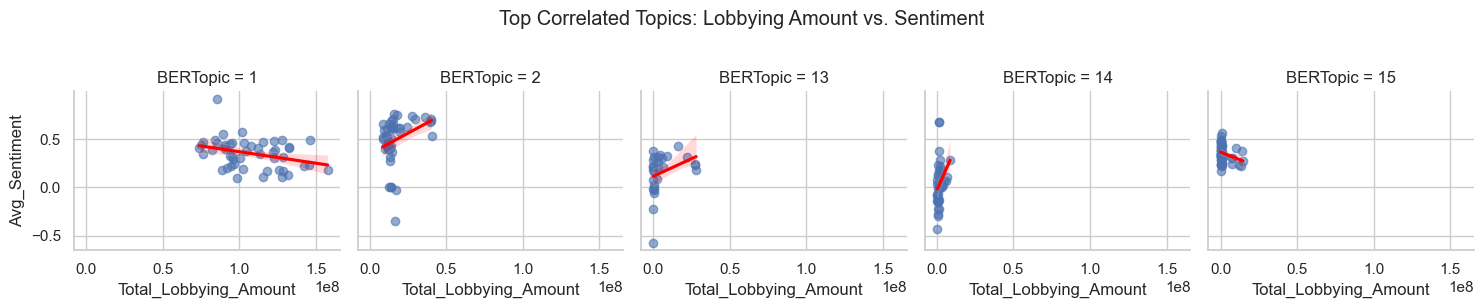

In [174]:
sns.set(style='whitegrid')
sns.lmplot(
    data=filtered_merged_bert_vader,
    x='Total_Lobbying_Amount',
    y='Avg_Sentiment',
    col='BERTopic',
    col_wrap=5,   # adjust depending on how many plots you want per row
    height=3,
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)

plt.suptitle('Top Correlated Topics: Lobbying Amount vs. Sentiment', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Collect results in a list
corr_results_bert = []

for topic in merged_df_bert_vader['BERTopic'].unique():
    sub_df = merged_df_bert_vader[merged_df_bert_vader['BERTopic'] == topic]
    
    if len(sub_df) >= 3:  # avoid very small samples
        r, p = pearsonr(sub_df['Total_Lobbying_Amount'], sub_df['Avg_Sentiment'])
        corr_results_bert.append({'BERTopic': topic, 'Pearson_r': r, 'p_value': p, 'n_obs': len(sub_df)})

# Sort by significance
df_corr_stats_bert = pd.DataFrame(corr_results_bert)
df_corr_stats_bert = df_corr_stats_bert.sort_values('p_value')


In [165]:
df_corr_stats_bert

,BERTopic,Pearson_r,p_value,n_obs
1,1,-0.327564,0.021588,49
2,2,0.320612,0.028007,47
13,15,-0.283978,0.047991,49
12,14,0.295926,0.051132,44
9,10,0.264920,0.071924,47
11,13,0.321815,0.094918,28
7,7,-0.196707,0.175520,49
15,20,-0.188527,0.194531,49
3,3,0.157663,0.295349,46
8,9,0.082860,0.584062,46


#### RoBERTa Model: Positive Sentiment

Correlation between lobbying and positive sentiment proportion: 0.113
P-value: 0.00255


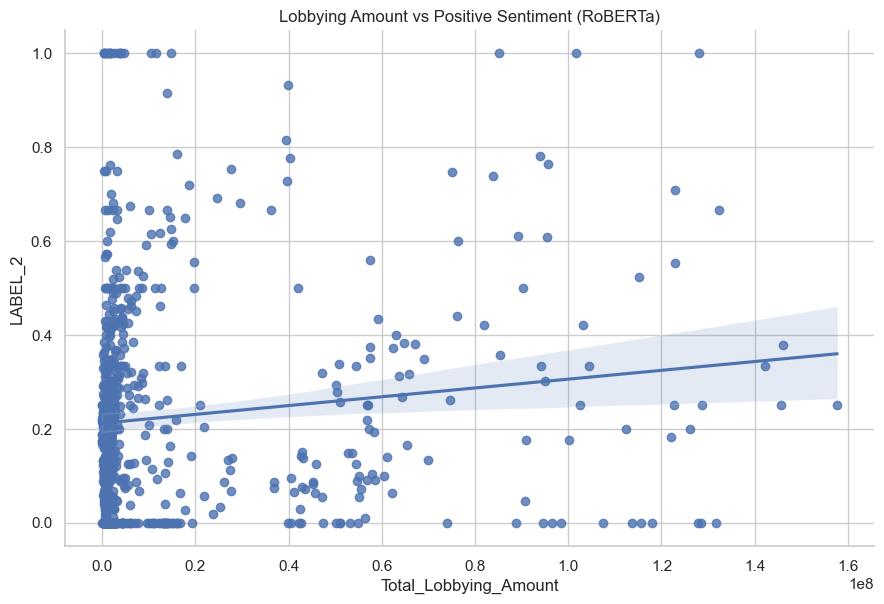

In [56]:
df_tweets['date'] = pd.to_datetime(df_tweets['date'])
df_tweets['Quarter'] = df_tweets['date'].dt.to_period('Q').astype(str)
df_tweets['Quarter'] = pd.PeriodIndex(df_tweets['Quarter'], freq='Q')

# filter for tweets with a softmax probability of over 0.7
threshold = 0.7
df_tweets_filtered = df_tweets[df_tweets['RoBERTa_Score'] >= threshold]

#  Group by BERTopic and Quarter and count sentiment labels
roberta_sentiment_counts_bert = df_tweets_filtered.groupby(
    ['BERTopic', 'Quarter', 'RoBERTa_Label']
).size().unstack(fill_value=0)

# Normalize to proportions
roberta_sentiment_props_bert = roberta_sentiment_counts_bert.div(
    roberta_sentiment_counts_bert.sum(axis=1), axis=0
).reset_index()

# Merge with lobbying amount
merged_roberta_bert = pd.merge(roberta_sentiment_props_bert, lobbying_by_topic_bert, on=['BERTopic', 'Quarter'], how='inner')

# Correlation between lobbying and proportion of positive sentiment
if 'LABEL_2' in merged_roberta_bert.columns:
    from scipy.stats import pearsonr

    corr_value, p_value = pearsonr(
        merged_roberta_bert['Total_Lobbying_Amount'],
        merged_roberta_bert['LABEL_2']  # Positive sentiment proportion
    )

    print(f'Correlation between lobbying and positive sentiment proportion: {corr_value:.3f}')
    print(f'P-value: {p_value:.5f}')

# Scatterplot
sns.lmplot(
    data=merged_roberta_bert,
    x='Total_Lobbying_Amount',
    y='LABEL_2',  # Positive sentiment
    height=6,
    aspect=1.5
)
plt.title('Lobbying Amount vs Positive Sentiment (RoBERTa)')
plt.grid(True)
plt.show()


#### RoBERTa Model: Negative Sentiment

Correlation between lobbying and negative sentiment proportion: -0.100
P-value: 0.00783


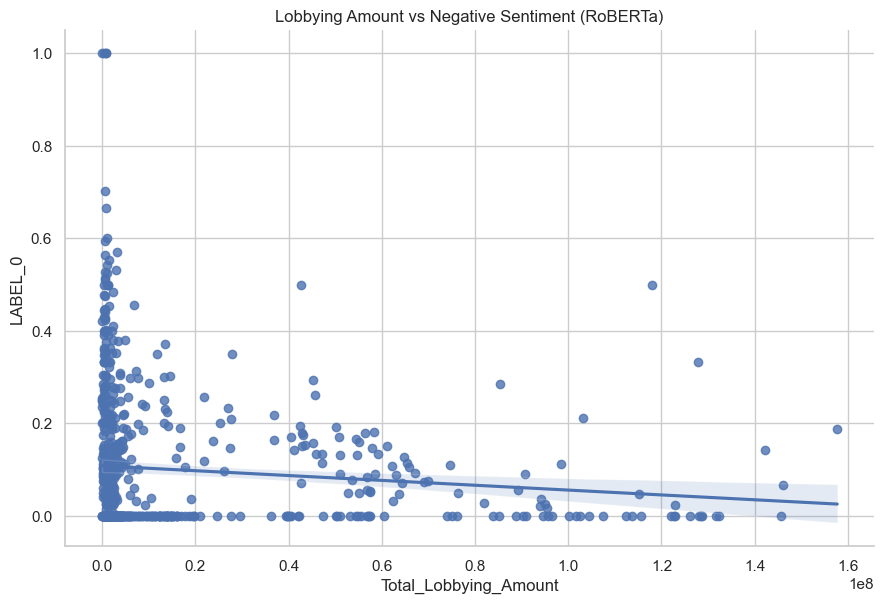

In [57]:
# Correlation between lobbying and proportion of positive sentiment
if 'LABEL_2' in merged_roberta_bert.columns:
    from scipy.stats import pearsonr

    corr_value, p_value = pearsonr(
        merged_roberta_bert['Total_Lobbying_Amount'],
        merged_roberta_bert['LABEL_0']  # Negative sentiment proportion
    )

    print(f'Correlation between lobbying and negative sentiment proportion: {corr_value:.3f}')
    print(f'P-value: {p_value:.5f}')

# Scatterplot
sns.lmplot(
    data=merged_roberta_bert,
    x='Total_Lobbying_Amount',
    y='LABEL_0',  # Negative sentiment
    height=6,
    aspect=1.5
)
plt.title('Lobbying Amount vs Negative Sentiment (RoBERTa)')
plt.grid(True)
plt.show()


In [58]:
merged_roberta_bert

,BERTopic,Quarter,LABEL_0,LABEL_1,LABEL_2,Total_Lobbying_Amount
0,0,2011Q1,0.000000,0.500000,0.500000,4.197177e+07
1,0,2011Q2,0.000000,1.000000,0.000000,4.229745e+07
2,0,2011Q3,0.500000,0.500000,0.000000,4.262101e+07
3,0,2011Q4,0.000000,1.000000,0.000000,4.053234e+07
4,0,2012Q1,0.000000,1.000000,0.000000,3.980313e+07
...,...,...,...,...,...,...
700,20,2022Q1,0.304284,0.652880,0.042836,6.819282e+05
701,20,2022Q2,0.353816,0.629832,0.016353,7.541708e+05
702,20,2022Q3,0.301391,0.686631,0.011978,7.709307e+05
703,20,2022Q4,0.282051,0.675214,0.042735,8.438523e+05


In [61]:
# Aggregate: Count positive and negative tweets per topic per quarter
sentiment_agg_roberta_bert = df_tweets_filtered.groupby(['BERTopic', 'Quarter', 'RoBERTa_Label']).size().unstack(fill_value=0).reset_index()

# Map label names
label_mapping = {'LABEL_0': 'Negative', 'LABEL_1': 'Neutral', 'LABEL_2': 'Positive'}
sentiment_agg_roberta_bert.rename(columns=label_mapping, inplace=True)

# Calculate proportions
sentiment_agg_roberta_bert['Total_Tweets'] = sentiment_agg_roberta_bert[['Negative', 'Neutral', 'Positive']].sum(axis=1)
sentiment_agg_roberta_bert['Positive_Proportion'] = sentiment_agg_roberta_bert['Positive'] / sentiment_agg_roberta_bert['Total_Tweets']
sentiment_agg_roberta_bert['Negative_Proportion'] = sentiment_agg_roberta_bert['Negative'] / sentiment_agg_roberta_bert['Total_Tweets']

# Merge with lobbying data
merged_df_roberta_bert = pd.merge(sentiment_agg_roberta_bert, lobbying_by_topic_bert, on=['BERTopic', 'Quarter'], how='inner')

# Prepare a results list
topic_results_roberta_bert = []

# Loop through topics
for topic_id in merged_df_roberta_bert['BERTopic'].unique():
    topic_data_roberta_bert = merged_df_roberta_bert[merged_df_roberta_bert['BERTopic'] == topic_id]
    
    if len(topic_data_roberta_bert) >= 5:  # Only analyze topics with enough data points
        # Positive correlation
        pos_corr, pos_pval = pearsonr(topic_data_roberta_bert['Total_Lobbying_Amount'], topic_data_roberta_bert['Positive_Proportion'])
        
        # Negative correlation
        neg_corr, neg_pval = pearsonr(topic_data_roberta_bert['Total_Lobbying_Amount'], topic_data_roberta_bert['Negative_Proportion'])
        
        topic_results_roberta_bert.append({
            'BERTopic': topic_id,
            'Positive_Corr': pos_corr,
            'Positive_Pval': pos_pval,
            'Negative_Corr': neg_corr,
            'Negative_Pval': neg_pval
        })

In [63]:
# Turn into DataFrame
topic_results_roberta_bert_df = pd.DataFrame(topic_results_roberta_bert)

# Sort to see strongest correlations
topic_results_roberta_bert_df = topic_results_roberta_bert_df.sort_values(by='Positive_Corr', ascending=False)

# View the most interesting topics
topic_results_roberta_bert_df.head(10)

,BERTopic,Positive_Corr,Positive_Pval,Negative_Corr,Negative_Pval
2,2,0.391191,0.007183,-0.110023,0.466682
0,0,0.371311,0.008621,0.027781,0.849715
3,3,0.368334,0.013890,0.455661,0.001882
5,5,0.275734,0.057836,0.119122,0.419998
9,10,0.197034,0.184350,-0.144736,0.331717
8,9,0.138656,0.381185,0.494458,0.000873
14,19,0.110396,0.475605,0.261286,0.086679
4,4,0.077900,0.615233,-0.335591,0.025947
12,14,-0.034093,0.834566,0.199327,0.217538
10,12,-0.062112,0.695974,0.001822,0.990862


### Temporal Sentiment Dynamics:
- How has sentiment evolved around specific policy issues over the past decade? This dimension examines whether shifts in sentiment correlate with lobbying intensity, and whether these patterns differ by party affiliation or individual legislator. (Kristian)

### Sponsor Alignment:
- Do bill sponsors exhibit sentiment that aligns with lobbying efforts around their sponsored legislation? While sponsors are generally expected to support their own bills, this analysis explores whether earlier sentiment shifts - preceding sponsorship - may indicate lobbying alignment or responsiveness. (Chris)

### Partisan Sentiment Patterns:
- Are there identifiable sentiment correlations - or divergences - across party lines? For example, when sentiment toward an issue grows more positive within one party, does it trigger a parallel or opposing trend in the other? This helps uncover whether lobbying activity contributes to polarization or convergence. (Kristian)

### Policy Output and Issue Attention:
- How does lobbying activity relate to the frequency and timing of bill introductions within specific issue categories? This dimension assesses whether lobbying serves to amplify legislative attention toward certain issues, and whether sentiment around those issues changes accordingly. (Christian)

### Legislative Feedback Effects:
- Once a bill is introduced, how does its presence influence sentiment in subsequent political discourse by other legislators? This analysis captures possible reactive sentiment shifts, indicating how lobbying-influenced legislation might shape broader political messaging. (Kristian)